In [55]:
# Cell 1: Data Loading and Setup
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.mask import mask
from shapely.geometry import Point, box
from pathlib import Path
import warnings
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds
from rasterio.mask import mask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
import os
import rasterio
import warnings
from sklearn.neighbors import NearestNeighbors
# from pykrige.ok import OrdinaryKriging
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import box
from shapely.geometry import Point
from scipy.interpolate import griddata
from dbfread import DBF
warnings.filterwarnings('ignore')

# Configuration
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

TARGET_CRS = 'EPSG:32632'  # UTM 32N
COHERENCE_THRESHOLD = 0.3
NODATA = -9999
CORINE_CLASSES = {
    1: 'Continuous urban fabric',
    2: 'Discontinuous urban fabric',
    3: 'Industrial or commercial units',
    4: 'Road and rail networks',
    5: 'Port areas',
    6: 'Airports',
    7: 'Mineral extraction sites',
    8: 'Dump sites',
    9: 'Construction sites',
    10: 'Green urban areas',
    11: 'Sport and leisure facilities',
    12: 'Non-irrigated arable land',
    13: 'Permanently irrigated land',
    14: 'Rice fields',
    15: 'Vineyards',
    16: 'Fruit trees and berry plantations',
    17: 'Olive groves',
    18: 'Pastures',
    19: 'Annual crops with permanent crops',
    20: 'Complex cultivation patterns',
    21: 'Agriculture with natural vegetation',
    22: 'Agro-forestry areas',
    23: 'Broad-leaved forest',
    24: 'Coniferous forest',
    25: 'Mixed forest',
    26: 'Natural grasslands',
    27: 'Moors and heathland',
    28: 'Sclerophyllous vegetation',
    29: 'Transitional woodland-shrub',
    30: 'Beaches, dunes, sands',
    31: 'Bare rocks',
    32: 'Sparsely vegetated areas',
    33: 'Burnt areas',
    34: 'Glaciers and perpetual snow',
    35: 'Inland marshes',
    36: 'Peat bogs',
    37: 'Salt marshes',
    38: 'Salines',
    39: 'Intertidal flats',
    40: 'Water courses',
    41: 'Water bodies',
    42: 'Coastal lagoons',
    43: 'Estuaries',
    44: 'Sea and ocean'
}
CORINE_COLORS = {
    # ARTIFICIAL SURFACES (1-11) - Red/Pink/Purple tones
    1: (230, 0, 77),        # Continuous urban fabric
    2: (255, 0, 0),         # Discontinuous urban fabric
    3: (204, 77, 242),      # Industrial or commercial units
    4: (204, 0, 0),         # Road and rail networks
    5: (230, 204, 204),     # Port areas
    6: (230, 204, 230),     # Airports
    7: (166, 0, 204),       # Mineral extraction sites
    8: (166, 77, 0),        # Dump sites
    9: (255, 77, 255),      # Construction sites
    10: (255, 166, 255),    # Green urban areas
    11: (255, 230, 255),    # Sport and leisure facilities

    # AGRICULTURAL AREAS (12-22) - Yellow/Brown tones
    12: (255, 255, 168),    # Non-irrigated arable land
    13: (255, 255, 0),      # Permanently irrigated land
    14: (230, 230, 0),      # Rice fields
    15: (230, 128, 0),      # Vineyards
    16: (242, 166, 77),     # Fruit trees and berry plantations
    17: (230, 166, 0),      # Olive groves
    18: (230, 230, 77),     # Pastures
    19: (255, 230, 166),    # Annual crops with permanent crops
    20: (255, 230, 77),     # Complex cultivation patterns
    21: (230, 204, 77),     # Agriculture with natural vegetation
    22: (242, 204, 166),    # Agro-forestry areas

    # FOREST AND SEMI NATURAL AREAS (23-34) - Green tones
    23: (128, 255, 0),      # Broad-leaved forest
    24: (0, 166, 0),        # Coniferous forest
    25: (77, 255, 0),       # Mixed forest
    26: (204, 242, 77),     # Natural grasslands
    27: (166, 230, 77),     # Moors and heathland
    28: (166, 166, 230),    # Sclerophyllous vegetation
    29: (0, 204, 0),        # Transitional woodland-shrub
    30: (240, 240, 240),    # Beaches, dunes, sands
    31: (204, 204, 204),    # Bare rocks
    32: (204, 255, 204),    # Sparsely vegetated areas
    33: (0, 0, 0),          # Burnt areas
    34: (166, 230, 204),    # Glaciers and perpetual snow

    # WETLANDS (35-39) - Blue/Cyan tones
    35: (166, 166, 255),    # Inland marshes
    36: (77, 77, 255),      # Peat bogs
    37: (204, 204, 255),    # Salt marshes
    38: (230, 230, 255),    # Salines
    39: (166, 166, 230),    # Intertidal flats

    # WATER BODIES (40-44) - Dark blue tones
    40: (0, 204, 242),      # Water courses
    41: (128, 242, 230),    # Water bodies
    42: (0, 255, 166),      # Coastal lagoons
    43: (166, 255, 230),    # Estuaries
    44: (230, 242, 255)     # Sea and ocean
}

# Convert RGB (0-255) to RGB (0-1) for matplotlib
CORINE_COLORS_MPL = {k: (r/255, g/255, b/255) for k, (r, g, b) in CORINE_COLORS.items()}
print("🚀 SAOCOM Point-Based Validation Setup")
print("="*50)







🚀 SAOCOM Point-Based Validation Setup


In [56]:
# ============================================================================
# 1. LOAD SAOCOM CSV POINTS
# ============================================================================
print("\n📍 Loading SAOCOM point data...")

saocom_files = list(DATA_DIR.glob("verona_v2*"))
if not saocom_files:
    raise FileNotFoundError("No SAOCOM CSV files found matching 'verona_v2*'")

# Load CSV with standardized column mapping
df = pd.read_csv(saocom_files[0], sep=',')
columns = ['ID', 'SVET', 'LVET', 'LAT', 'LON', 'HEIGHT', 'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']
df.columns = columns

# Convert to numeric and clean
for col in ['LAT', 'LON', 'HEIGHT', 'COHER']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove invalid points
df = df.dropna(subset=['LAT', 'LON', 'HEIGHT', 'COHER'])
df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

print(f"   Raw points loaded: {len(df):,}")

# Apply coherence filtering
df_filtered = df[df['COHER'] >= COHERENCE_THRESHOLD]
print(f"   Points after coherence filter (≥{COHERENCE_THRESHOLD}): {len(df_filtered):,}")
print(f"   Points removed: {len(df) - len(df_filtered):,} ({100*(len(df) - len(df_filtered))/len(df):.1f}%)")

# Create GeoDataFrame and reproject to UTM 32N
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered['LON'], df_filtered['LAT'])]
saocom_gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs='EPSG:4326')
saocom_gdf = saocom_gdf.to_crs(TARGET_CRS)

# Add UTM coordinates
saocom_gdf['x_utm'] = saocom_gdf.geometry.x
saocom_gdf['y_utm'] = saocom_gdf.geometry.y

print(f"   ✓ SAOCOM points reprojected to {TARGET_CRS}")
print(f"   Coherence range: {df_filtered['COHER'].min():.3f} - {df_filtered['COHER'].max():.3f}")
print(f"   Height range: {df_filtered['HEIGHT'].min():.1f} - {df_filtered['HEIGHT'].max():.1f} m")




📍 Loading SAOCOM point data...
   Raw points loaded: 66,791
   Points after coherence filter (≥0.3): 66,791
   Points removed: 0 (0.0%)
   ✓ SAOCOM points reprojected to EPSG:32632
   Coherence range: 0.700 - 1.000
   Height range: -562.0 - 1163.7 m


In [57]:
# ============================================================================
# 2. LOAD REFERENCE DEMs
# ============================================================================
print("\n🏔️  Loading reference DEMs...")

reference_dems = {}
dem_patterns = {
    'tinitaly_crop': '*tinitaly_crop*',
    'copernicus': '*GLO30*'
}

for name, pattern in dem_patterns.items():
    dem_files = list(DATA_DIR.glob(f"{pattern}.tif")) + list(DATA_DIR.glob(f"{pattern}.TIF"))

    if dem_files:
        dem_path = dem_files[0]

        # Verify DEM can be opened and get basic info
        with rasterio.open(dem_path) as src:
            print(f"   📁 {name.upper()}: {dem_path.name}")
            print(f"      CRS: {src.crs}")
            print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
            print(f"      Bounds: {src.bounds}")

            # Check if already in target CRS
            needs_reproject = str(src.crs) != TARGET_CRS
            print(f"      Needs reprojection: {needs_reproject}")

        reference_dems[name] = {
            'path': dem_path,
            'needs_reproject': needs_reproject
        }
    else:
        print(f"   ⚠️  {name.upper()}: No files found matching '{pattern}'")

print(f"\n   ✓ Found {len(reference_dems)} reference DEMs")


🏔️  Loading reference DEMs...
   📁 TINITALY_CROP: tinitaly_crop.tif
      CRS: EPSG:32632
      Resolution: 10.0m x 10.0m
      Bounds: BoundingBox(left=663160.0, bottom=5035530.0, right=674300.0, top=5046650.0)
      Needs reprojection: False
   📁 COPERNICUS: GLO30.tif
      CRS: EPSG:4326
      Resolution: 0.0m x 0.0m
      Bounds: BoundingBox(left=11.08958332222224, bottom=45.453750011111104, right=11.229861100000017, top=45.55208334444444)
      Needs reprojection: True

   ✓ Found 2 reference DEMs



🌍 Processing CORINE land cover data...
✓ Found CORINE: lclu_crop.tif
✓ DBF file found
   DBF columns: ['Value', 'Count']
   Records: 29
   Original CRS: EPSG:4326
   Original resolution: 0.0m
   Valid CORINE codes: 29
   ✓ Resampled to 10m: 1114 x 1112
   Smoothing boundaries...
   ✓ Saved: corine_10m_smoothed.tif


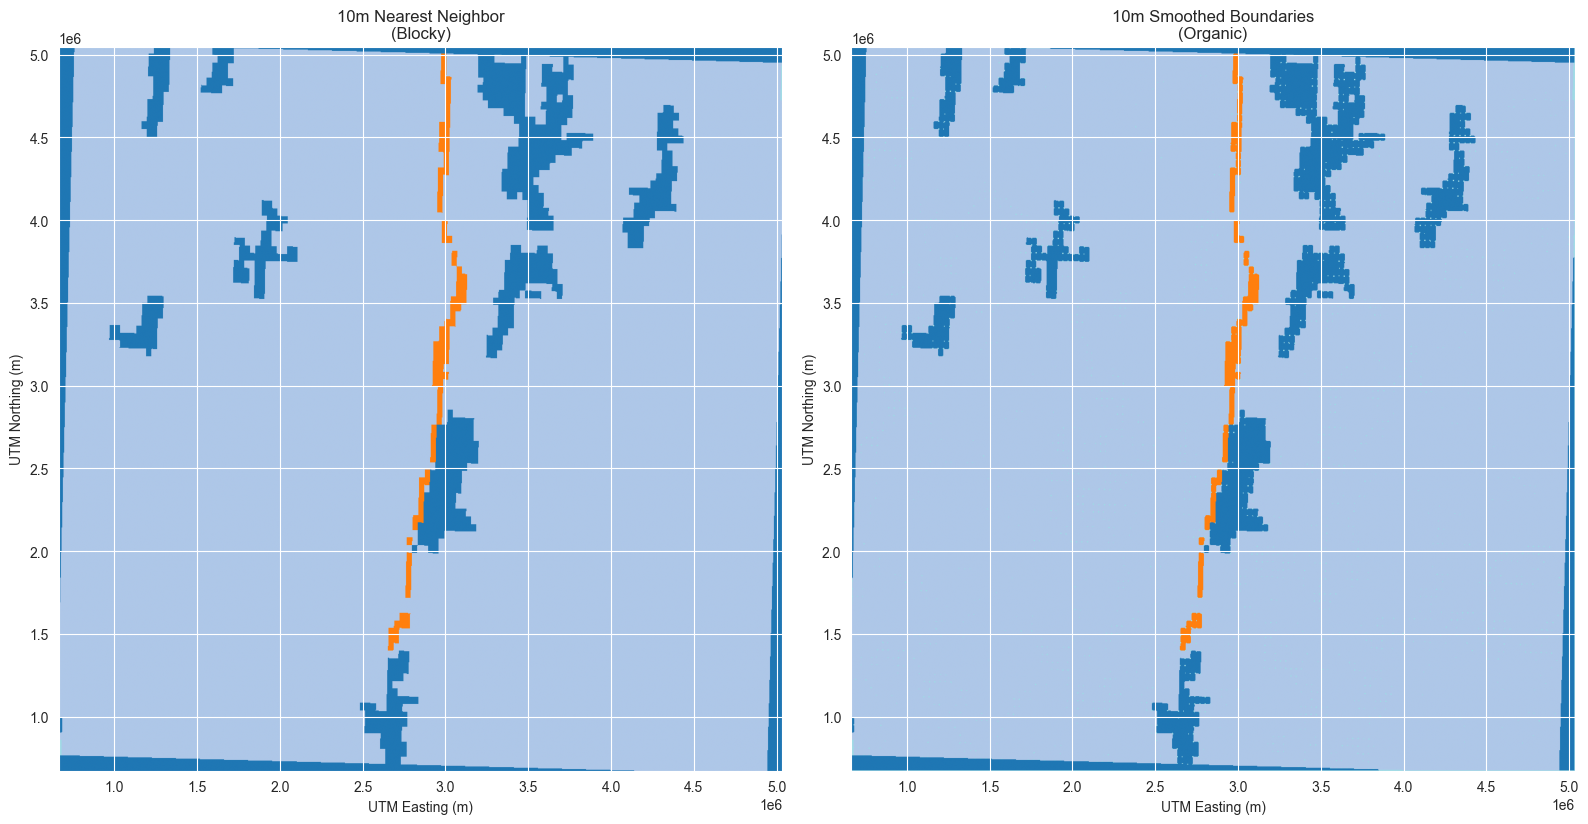

✅ CORINE processing complete!


In [58]:
# Cell 1 Addition: Process CORINE with smoothing
from dbfread import DBF
from scipy.ndimage import median_filter
from rasterio.mask import mask
from shapely.geometry import box

print("\n🌍 Processing CORINE land cover data...")

# Load CORINE files
corine_file = "lclu_crop.tif"
# corine_file = "U2018_CLC2018_V2020_20u1.tif"

corine_path = DATA_DIR / corine_file

if not corine_path.exists():
    print(f"Error: {corine_file} not found")
else:
    print(f"✓ Found CORINE: {corine_file}")

    # Load associated DBF
    vat_dbf_path_list = list(DATA_DIR.glob(f"{corine_file}.vat.dbf"))
    if not vat_dbf_path_list:
        print(f"Error: .dbf file not found for {corine_file}")
    else:
        print('✓ DBF file found')
        vat_dbf_path = vat_dbf_path_list[0]
        dbf_table = DBF(vat_dbf_path, load=True)

        # Create lookup table
        lookup_df = pd.DataFrame(iter(dbf_table))
        print(f"   DBF columns: {list(lookup_df.columns)}")
        print(f"   Records: {len(lookup_df)}")

# Get TINITALY extent for clipping
if 'tinitaly_crop' in reference_dems:
    with rasterio.open(reference_dems['tinitaly_crop']['path']) as tinitaly_src:
        # Get bounds in CORINE CRS
        tinitaly_bounds = tinitaly_src.bounds
        if str(tinitaly_src.crs) != TARGET_CRS:
            from rasterio.warp import transform_bounds
            clip_bounds = transform_bounds(tinitaly_src.crs, TARGET_CRS, *tinitaly_bounds)
        else:
            clip_bounds = tinitaly_bounds

        # Create clipping geometry
        clip_geom = box(*clip_bounds)
        clip_gdf = gpd.GeoDataFrame([1], geometry=[clip_geom], crs=TARGET_CRS)

# Process CORINE
with rasterio.open(corine_path) as corine_src:
    print(f"   Original CRS: {corine_src.crs}")
    print(f"   Original resolution: {corine_src.res[0]:.1f}m")

    # Reproject clipping geometry to CORINE CRS if needed
    if str(corine_src.crs) != TARGET_CRS:
        clip_gdf_corine = clip_gdf.to_crs(corine_src.crs)
    else:
        clip_gdf_corine = clip_gdf

    # Clip CORINE to study area
    clipped_corine, clipped_transform = mask(corine_src, clip_gdf_corine.geometry, crop=True)
    clipped_corine = clipped_corine[0]

    # Filter out non-existent values using DBF
    valid_values = set(lookup_df['Value'].values) if 'Value' in lookup_df.columns else set(lookup_df.iloc[:,0].values)
    print(f"   Valid CORINE codes: {len(valid_values)}")

    # Mask invalid values
    valid_mask = np.isin(clipped_corine, list(valid_values))
    clipped_corine[~valid_mask] = corine_src.nodata or 255

# Resample to 10m grid
target_width = int((clip_bounds[2] - clip_bounds[0]) / 10)
target_height = int((clip_bounds[3] - clip_bounds[1]) / 10)
target_transform = from_bounds(*clip_bounds, target_width, target_height)

# Create 10m resampled array
resampled_10m = np.full((target_height, target_width), 255, dtype=np.uint8)

reproject(
    source=clipped_corine,
    destination=resampled_10m,
    src_transform=clipped_transform,
    src_crs=corine_src.crs,
    dst_transform=target_transform,
    dst_crs=TARGET_CRS,
    resampling=Resampling.nearest
)

print(f"   ✓ Resampled to 10m: {target_width} x {target_height}")

# Smooth boundaries with median filter
print("   Smoothing boundaries...")
smoothed_corine = median_filter(resampled_10m, size=3)

# Apply additional morphological smoothing
from scipy.ndimage import binary_opening, binary_closing
from skimage.morphology import disk

final_smooth = np.full_like(smoothed_corine, 255)
selem = disk(1)

for value in np.unique(smoothed_corine[smoothed_corine != 255]):
    mask = (smoothed_corine == value)
    opened = binary_opening(mask, selem)
    closed = binary_closing(opened, selem)
    final_smooth[closed] = value

# Save smoothed CORINE
corine_output_path = RESULTS_DIR / "corine_10m_smoothed.tif"
profile = {
    'driver': 'GTiff', 'dtype': 'uint8', 'width': target_width, 'height': target_height,
    'count': 1, 'crs': TARGET_CRS, 'transform': target_transform,
    'nodata': 255, 'compress': 'lzw'
}

with rasterio.open(corine_output_path, 'w', **profile) as dst:
    dst.write(final_smooth, 1)

print(f"   ✓ Saved: {corine_output_path.name}")

# Display the smoothed result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Original blocky
ax1.imshow(resampled_10m, extent=clip_bounds, cmap='tab20', origin='lower')
ax1.set_title('10m Nearest Neighbor\n(Blocky)')
ax1.set_xlabel('UTM Easting (m)')
ax1.set_ylabel('UTM Northing (m)')

# Smoothed
im2 = ax2.imshow(final_smooth, extent=clip_bounds, cmap='tab20', origin='lower')
ax2.set_title('10m Smoothed Boundaries\n(Organic)')
ax2.set_xlabel('UTM Easting (m)')
ax2.set_ylabel('UTM Northing (m)')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'corine_smoothing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Update corine_data for later use
corine_data = {
    'path': corine_output_path,
    'type': 'raster_smoothed',
    'lookup_table': {'lookup_df': lookup_df},
    'is_10m': True,
    'needs_reproject': False
}

print("✅ CORINE processing complete!")

In [59]:
# ============================================================================
# 4. SUMMARY AND STUDY AREA BOUNDS
# ============================================================================
print("\n📏 Study area summary...")

# Get study area bounds from SAOCOM points
study_bounds = saocom_gdf.total_bounds
xmin, ymin, xmax, ymax = study_bounds

print(f"   Study area bounds (UTM 32N):")
print(f"      X: {xmin:,.0f} - {xmax:,.0f} m")
print(f"      Y: {ymin:,.0f} - {ymax:,.0f} m")
print(f"      Width: {(xmax-xmin)/1000:.1f} km")
print(f"      Height: {(ymax-ymin)/1000:.1f} km")

# Create study area polygon for clipping
study_area_poly = box(xmin, ymin, xmax, ymax)
study_area_gdf = gpd.GeoDataFrame([1], geometry=[study_area_poly], crs=TARGET_CRS)

print(f"\n✅ Data loading complete!")
print(f"   SAOCOM points: {len(saocom_gdf):,}")
print(f"   Reference DEMs: {len(reference_dems)}")
print(f"   Land cover: {'✓' if corine_data else '✗'}")
print(f"   All data will be processed in {TARGET_CRS}")

# Store key variables for next cells
loaded_data = {
    'saocom_gdf': saocom_gdf,
    'reference_dems': reference_dems,
    'corine_data': corine_data,
    'study_bounds': study_bounds,
    'study_area_gdf': study_area_gdf,
    'coherence_threshold': COHERENCE_THRESHOLD
}

print(f"\n📋 Ready for Cell 2: Spatial Coverage Analysis")



📏 Study area summary...
   Study area bounds (UTM 32N):
      X: 664,943 - 674,223 m
      Y: 5,037,632 - 5,045,391 m
      Width: 9.3 km
      Height: 7.8 km

✅ Data loading complete!
   SAOCOM points: 66,791
   Reference DEMs: 2
   Land cover: ✓
   All data will be processed in EPSG:32632

📋 Ready for Cell 2: Spatial Coverage Analysis


In [60]:
# ============================================================================
# 5. RESAMPLE REFERENCE DEMs TO 10m GRID
# ============================================================================
print("\n🔧 Resampling reference DEMs to 10m grid...")

# Use study area bounds from SAOCOM for consistent grid
xmin_grid = np.floor(study_bounds[0] / 10) * 10
ymin_grid = np.floor(study_bounds[1] / 10) * 10
xmax_grid = np.ceil(study_bounds[2] / 10) * 10
ymax_grid = np.ceil(study_bounds[3] / 10) * 10

# Calculate grid dimensions
width = int((xmax_grid - xmin_grid) / 10)
height = int((ymax_grid - ymin_grid) / 10)
target_transform = rasterio.transform.from_bounds(xmin_grid, ymin_grid, xmax_grid, ymax_grid, width, height)

resampled_dems = {}

for name, dem_info in reference_dems.items():
    print(f"   Resampling {name.upper()}...")

    output_path = RESULTS_DIR / f"{name}_10m_resampled.tif"

    with rasterio.open(dem_info['path']) as src:
        # Create output array
        output_array = np.full((height, width), NODATA, dtype=np.float32)

        # Reproject to 10m grid
        reproject(
            source=rasterio.band(src, 1),
            destination=output_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=target_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.cubic,
            src_nodata=src.nodata,
            dst_nodata=NODATA
        )

        # Save resampled DEM
        profile = {
            'driver': 'GTiff',
            'dtype': 'float32',
            'width': width,
            'height': height,
            'count': 1,
            'crs': TARGET_CRS,
            'transform': target_transform,
            'nodata': NODATA,
            'compress': 'lzw'
        }

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(output_array, 1)

        # Verify resampling
        valid_pixels = np.sum(output_array != NODATA)
        print(f"      ✓ Saved: {output_path.name}")
        print(f"      Resolution: 10m x 10m")
        print(f"      Dimensions: {width} x {height}")
        print(f"      Valid pixels: {valid_pixels:,}")

    resampled_dems[name] = output_path

print(f"\n✅ All reference DEMs resampled to 10m resolution!")

# Update the reference_dems dict to point to resampled versions
for name in reference_dems.keys():
    reference_dems[name]['resampled_path'] = resampled_dems[name]
    reference_dems[name]['is_10m'] = True

# Update loaded_data
loaded_data.update({
    'resampled_dems': resampled_dems,
    'target_transform': target_transform,
    'grid_bounds_10m': (xmin_grid, ymin_grid, xmax_grid, ymax_grid)
})



🔧 Resampling reference DEMs to 10m grid...
   Resampling TINITALY_CROP...
      ✓ Saved: tinitaly_crop_10m_resampled.tif
      Resolution: 10m x 10m
      Dimensions: 929 x 777
      Valid pixels: 656,620
   Resampling COPERNICUS...
      ✓ Saved: copernicus_10m_resampled.tif
      Resolution: 10m x 10m
      Dimensions: 929 x 777
      Valid pixels: 718,137

✅ All reference DEMs resampled to 10m resolution!


In [61]:
# Cell 2: Spatial Coverage Analysis ("Extract Voids")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import seaborn as sns
from collections import Counter

print("🗺️  SPATIAL COVERAGE ANALYSIS")
print("="*50)

# Configuration for grid analysis
GRID_SIZE = 10  # meters - balance between detail and computation
print(f"Grid cell size: {GRID_SIZE}m x {GRID_SIZE}m")

# ============================================================================
# 1. CREATE STUDY AREA BOUNDARY RASTER GRID
# ============================================================================
print("\n📐 Creating study area grid...")

# Expand bounds slightly to ensure full coverage
xmin, ymin, xmax, ymax = study_bounds
buffer = GRID_SIZE * 2  # Add 2-cell buffer
xmin_grid = xmin - buffer
ymin_grid = ymin - buffer
xmax_grid = xmax + buffer
ymax_grid = ymax + buffer

# Create grid coordinates
x_coords = np.arange(xmin_grid, xmax_grid + GRID_SIZE, GRID_SIZE)
y_coords = np.arange(ymin_grid, ymax_grid + GRID_SIZE, GRID_SIZE)

# Create meshgrid for cell centers
x_centers = x_coords[:-1] + GRID_SIZE/2
y_centers = y_coords[:-1] + GRID_SIZE/2
grid_x, grid_y = np.meshgrid(x_centers, y_centers)

# Flatten for easier processing
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
n_cells = len(grid_points)

print(f"   Grid dimensions: {len(x_centers)} x {len(y_centers)} = {n_cells:,} cells")
print(f"   Grid covers: {(xmax_grid-xmin_grid)/1000:.1f} x {(ymax_grid-ymin_grid)/1000:.1f} km")

# Create grid cell IDs
grid_ids = np.arange(n_cells)
grid_df = pd.DataFrame({
    'grid_id': grid_ids,
    'x_center': grid_points[:, 0],
    'y_center': grid_points[:, 1],
    'has_saocom': False,
    'n_saocom_points': 0
})

# ============================================================================
# 2. MAP SAOCOM POINT LOCATIONS TO GRID CELLS
# ============================================================================
print("\n📍 Mapping SAOCOM points to grid cells...")

# Create BallTree for efficient spatial queries
saocom_coords = np.column_stack([saocom_gdf['x_utm'], saocom_gdf['y_utm']])
tree = BallTree(saocom_coords, metric='euclidean')

# For each grid cell, find SAOCOM points within GRID_SIZE/2 distance
search_radius = GRID_SIZE / 2 * np.sqrt(2)  # Diagonal of grid cell

grid_saocom_counts = []
for i, (x, y) in enumerate(grid_points):
    # Find points within grid cell
    indices = tree.query_radius([[x, y]], r=search_radius)[0]

    # Filter to points actually in this grid cell (square, not circle)
    if len(indices) > 0:
        pts_x = saocom_coords[indices, 0]
        pts_y = saocom_coords[indices, 1]

        # Check if points are within square grid cell
        in_cell = ((pts_x >= x - GRID_SIZE/2) & (pts_x < x + GRID_SIZE/2) &
                   (pts_y >= y - GRID_SIZE/2) & (pts_y < y + GRID_SIZE/2))

        n_points = np.sum(in_cell)
    else:
        n_points = 0

    grid_saocom_counts.append(n_points)

# Update grid dataframe
grid_df['n_saocom_points'] = grid_saocom_counts
grid_df['has_saocom'] = grid_df['n_saocom_points'] > 0

# ============================================================================
# 3. IDENTIFY VOID CELLS
# ============================================================================
print("\n🕳️  Identifying void cells...")

# Basic void analysis
n_total_cells = len(grid_df)
n_occupied_cells = np.sum(grid_df['has_saocom'])
n_void_cells = n_total_cells - n_occupied_cells
void_percentage = 100 * n_void_cells / n_total_cells

print(f"   Total grid cells: {n_total_cells:,}")
print(f"   Cells with SAOCOM data: {n_occupied_cells:,}")
print(f"   Void cells: {n_void_cells:,}")
print(f"   Void percentage: {void_percentage:.1f}%")

# Point density statistics
occupied_cells = grid_df[grid_df['has_saocom']]
if len(occupied_cells) > 0:
    print(f"\n   Point density in occupied cells:")
    print(f"      Mean: {occupied_cells['n_saocom_points'].mean():.1f} points/cell")
    print(f"      Median: {occupied_cells['n_saocom_points'].median():.1f} points/cell")
    print(f"      Max: {occupied_cells['n_saocom_points'].max()} points/cell")

# ============================================================================
# 4. EXTRACT LAND COVER FOR GRID CELLS (if available)
# ============================================================================
# Updated CORINE extraction for Cell 2:

if corine_data is not None:
    print("\n🌱 Extracting land cover for 10m grid cells...")

    if corine_data['type'] == 'raster_smoothed':
        # Extract from smoothed 10m raster (already in correct CRS and resolution)
        with rasterio.open(corine_data['path']) as src:
            print(f"      Using smoothed 10m CORINE raster")

            # Sample land cover at grid points
            coords = [(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
            land_cover_values = list(src.sample(coords))
            raw_values = [val[0] if val[0] != src.nodata else np.nan for val in land_cover_values]

            # Apply lookup table if available to get CORINE codes/labels
            if 'lookup_table' in corine_data and 'lookup_df' in corine_data['lookup_table']:
                lookup_df = corine_data['lookup_table']['lookup_df']
                print(f"      Applying lookup table with {len(lookup_df)} entries")

                # Create value-to-code mapping from DBF
                if 'Value' in lookup_df.columns and 'CLC_CODE' in lookup_df.columns:
                    value_to_code = dict(zip(lookup_df['Value'], lookup_df['CLC_CODE']))
                    corine_codes = [value_to_code.get(val, np.nan) if not pd.isna(val) else np.nan
                                   for val in raw_values]
                    grid_df['land_cover'] = corine_codes
                    grid_df['land_cover_raw'] = raw_values

                    # Also get labels if available
                    if 'LABEL3' in lookup_df.columns:
                        value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
                        grid_df['land_cover_label'] = [value_to_label.get(val, 'Unknown') if not pd.isna(val) else 'No Data'
                                                      for val in raw_values]

                    print(f"      ✓ Mapped to CORINE codes using lookup table")
                else:
                    # Use raw values if lookup structure is different
                    grid_df['land_cover'] = raw_values
                    print(f"      Using raw raster values (lookup columns not found)")
            else:
                grid_df['land_cover'] = raw_values
                print(f"      Using raw raster values (no lookup table)")

    elif corine_data['type'] == 'raster':
        # Original raster handling (if needed)
        with rasterio.open(corine_data['path']) as src:
            if corine_data['needs_reproject']:
                print("      (Reprojecting CORINE on-the-fly)")

            coords = [(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
            land_cover_values = list(src.sample(coords))
            grid_df['land_cover'] = [val[0] if val[0] != src.nodata else np.nan for val in land_cover_values]

    elif corine_data['type'] == 'vector':
        # Spatial join with vector data
        grid_geometry = [Point(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
        grid_gdf = gpd.GeoDataFrame(grid_df, geometry=grid_geometry, crs=TARGET_CRS)

        if corine_data['needs_reproject']:
            corine_reproj = corine_data['gdf'].to_crs(TARGET_CRS)
        else:
            corine_reproj = corine_data['gdf']

        # Assuming land cover code is in a column like 'CODE_18' or 'code'
        lc_columns = [col for col in corine_reproj.columns if 'code' in col.lower()]
        if lc_columns:
            lc_col = lc_columns[0]
            joined = gpd.sjoin(grid_gdf, corine_reproj[[lc_col, 'geometry']], how='left', predicate='within')
            grid_df['land_cover'] = joined[lc_col].values
        else:
            print("      Warning: No land cover code column found")
            grid_df['land_cover'] = np.nan

    # Calculate void percentage by land cover class
    print("\n   Void percentage by land cover class (top 10):")

    valid_lc = grid_df['land_cover'].dropna()
    if len(valid_lc) > 0:
        lc_void_stats = grid_df.groupby('land_cover').agg({
            'has_saocom': ['count', 'sum'],
            'n_saocom_points': 'sum'
        })

        lc_void_stats.columns = ['total_cells', 'occupied_cells', 'total_points']
        lc_void_stats['void_cells'] = lc_void_stats['total_cells'] - lc_void_stats['occupied_cells']
        lc_void_stats['void_percentage'] = 100 * lc_void_stats['void_cells'] / lc_void_stats['total_cells']
        lc_void_stats = lc_void_stats.sort_values('total_cells', ascending=False).head(10)

        # Add land cover labels if available
        if 'land_cover_label' in grid_df.columns:
            # Get most common label for each code
            code_to_label = grid_df.groupby('land_cover')['land_cover_label'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown')
            lc_void_stats['label'] = lc_void_stats.index.map(code_to_label)
            print(lc_void_stats[['total_cells', 'void_percentage', 'label']].round(1))
        else:
            print(lc_void_stats[['total_cells', 'void_percentage']].round(1))

        print(f"      ✓ Extracted land cover for {len(valid_lc):,} grid cells")
    else:
        print("      No valid land cover data extracted")

else:
    print("\n⚠️  No CORINE data available - skipping land cover analysis")
    grid_df['land_cover'] = np.nan


🗺️  SPATIAL COVERAGE ANALYSIS
Grid cell size: 10m x 10m

📐 Creating study area grid...
   Grid dimensions: 933 x 780 = 727,740 cells
   Grid covers: 9.3 x 7.8 km

📍 Mapping SAOCOM points to grid cells...

🕳️  Identifying void cells...
   Total grid cells: 727,740
   Cells with SAOCOM data: 64,158
   Void cells: 663,582
   Void percentage: 91.2%

   Point density in occupied cells:
      Mean: 1.0 points/cell
      Median: 1.0 points/cell
      Max: 4 points/cell

🌱 Extracting land cover for 10m grid cells...
      Using smoothed 10m CORINE raster
      Applying lookup table with 29 entries
      Using raw raster values (lookup columns not found)

   Void percentage by land cover class (top 10):
            total_cells  void_percentage
land_cover                              
23.0             165776             92.9
21.0             154913             93.1
15.0             144113             87.4
22.0              55184             92.6
18.0              42265             91.8
20.0     

In [62]:
# ============================================================================
# 5. TERRAIN CHARACTERISTICS (if reference DEMs available)
# ============================================================================


if 'tinitaly' in reference_dems:
    print("\n⛰️  Extracting terrain characteristics...")

    with rasterio.open(reference_dems['tinitaly']['path']) as src:
        # Sample elevation at grid points
        coords = [(x, y) for x, y in zip(grid_df['x_center'], grid_df['y_center'])]
        elevation_values = list(src.sample(coords))
        grid_df['elevation'] = [val[0] if val[0] != src.nodata else np.nan for val in elevation_values]

    # Create elevation bins for analysis
    valid_elevations = grid_df['elevation'].dropna()
    if len(valid_elevations) > 0:
        elevation_bins = pd.qcut(valid_elevations, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        grid_df['elevation_bin'] = pd.qcut(grid_df['elevation'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')

        # Void percentage by elevation
        print("\n   Void percentage by elevation bin:")
        elev_void_stats = grid_df.groupby('elevation_bin').agg({
            'has_saocom': ['count', 'sum']
        })
        elev_void_stats.columns = ['total_cells', 'occupied_cells']
        elev_void_stats['void_percentage'] = 100 * (elev_void_stats['total_cells'] - elev_void_stats['occupied_cells']) / elev_void_stats['total_cells']
        print(elev_void_stats)

In [63]:
# Cell 3: Point Density Analysis (with detailed explanations)
from sklearn.neighbors import KernelDensity
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

print("📊 POINT DENSITY ANALYSIS")
print("="*50)

# ============================================================================
# 1. BASIC POINT DENSITY CALCULATION
# ============================================================================
print("\n📍 Calculating basic point density...")

# Calculate overall density
study_area_km2 = (coverage_analysis['n_total_cells'] * (coverage_analysis['grid_size']/1000)**2)
overall_density = len(saocom_gdf) / study_area_km2

print(f"   Study area: {study_area_km2:.2f} km²")
print(f"   Total SAOCOM points: {len(saocom_gdf):,}")
print(f"   Overall density: {overall_density:.1f} points/km²")

# Calculate density per occupied cell
occupied_cells = coverage_analysis['n_occupied_cells']
occupied_area_km2 = occupied_cells * (coverage_analysis['grid_size']/1000)**2
effective_density = len(saocom_gdf) / occupied_area_km2

print(f"   Occupied area: {occupied_area_km2:.2f} km² ({100*occupied_cells/coverage_analysis['n_total_cells']:.1f}% of study area)")
print(f"   Effective density: {effective_density:.1f} points/km² (in areas with data)")

# ============================================================================
# 2. KERNEL DENSITY ESTIMATION SURFACE
# ============================================================================
print("\n🌡️  Creating density surface using KDE...")

# Use SAOCOM point coordinates
saocom_coords = np.column_stack([saocom_gdf['x_utm'], saocom_gdf['y_utm']])

# Create dense grid for KDE (every 50m for efficiency)
kde_resolution = 50  # meters
xmin, ymin, xmax, ymax = coverage_analysis['grid_bounds']

x_kde = np.arange(xmin, xmax, kde_resolution)
y_kde = np.arange(ymin, ymax, kde_resolution)
kde_grid_x, kde_grid_y = np.meshgrid(x_kde, y_kde)
kde_points = np.column_stack([kde_grid_x.ravel(), kde_grid_y.ravel()])

# Fit KDE with appropriate bandwidth
bandwidth = 100  # Reduce from 500m to 100m
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(saocom_coords)

# Calculate density surface
kde_scores = kde.score_samples(kde_points)
kde_density = np.exp(kde_scores)

# Convert to points/km²
total_points = len(saocom_gdf)
kde_density_km2 = kde_density * total_points * (1000**2)  # Scale to points/km²

kde_density_km2 = kde_density_km2.reshape(kde_grid_x.shape)

print(f"   KDE bandwidth: {bandwidth}m")
print(f"   KDE grid resolution: {kde_resolution}m")
print(f"   Density range: {kde_density_km2.min():.1f} - {kde_density_km2.max():.1f} points/km²")

# ============================================================================
# 3. TERRAIN CHARACTERISTICS (Slope/Aspect)
# ============================================================================
if 'tinitaly' in reference_dems:
    print("\n⛰️  Calculating terrain characteristics...")

    # Load elevation data
    with rasterio.open(reference_dems['tinitaly']['resampled_path']) as src:
        elevation = src.read(1).astype(float)
        elevation[elevation == src.nodata] = np.nan
        dem_transform = src.transform

    # Calculate slope using Sobel filters
    grad_x = sobel(elevation, axis=1)
    grad_y = sobel(elevation, axis=0)
    slope_radians = np.arctan(np.sqrt(grad_x**2 + grad_y**2))
    slope_degrees = np.degrees(slope_radians)

    # Calculate aspect
    aspect_radians = np.arctan2(grad_y, grad_x)
    aspect_degrees = np.degrees(aspect_radians)
    aspect_degrees[aspect_degrees < 0] += 360  # Convert to 0-360°

    print(f"   Slope range: {np.nanmin(slope_degrees):.1f}° - {np.nanmax(slope_degrees):.1f}°")
    print(f"   Mean slope: {np.nanmean(slope_degrees):.1f}°")

    # Extract slope/aspect at SAOCOM point locations
    def extract_raster_values_at_points(raster_array, transform, points_x, points_y):
        rows, cols = rasterio.transform.rowcol(transform, points_x, points_y)
        # Clip to valid indices
        valid_mask = (rows >= 0) & (rows < raster_array.shape[0]) & (cols >= 0) & (cols < raster_array.shape[1])
        values = np.full(len(points_x), np.nan)
        values[valid_mask] = raster_array[rows[valid_mask], cols[valid_mask]]
        return values

    saocom_slope = extract_raster_values_at_points(slope_degrees, dem_transform,
                                                  saocom_gdf['x_utm'], saocom_gdf['y_utm'])
    saocom_aspect = extract_raster_values_at_points(aspect_degrees, dem_transform,
                                                   saocom_gdf['x_utm'], saocom_gdf['y_utm'])

    # Add to SAOCOM dataframe
    saocom_gdf['slope'] = saocom_slope
    saocom_gdf['aspect'] = saocom_aspect

    # Create slope bins
    slope_bins = [0, 5, 15, 30, 45, 90]
    slope_labels = ['Flat (0-5°)', 'Gentle (5-15°)', 'Moderate (15-30°)', 'Steep (30-45°)', 'Very Steep (>45°)']
    saocom_gdf['slope_class'] = pd.cut(saocom_gdf['slope'], bins=slope_bins, labels=slope_labels, include_lowest=True)

else:
    print("\n⚠️  No DEM available - skipping slope/aspect analysis")
    saocom_gdf['slope'] = np.nan
    saocom_gdf['aspect'] = np.nan
    saocom_gdf['slope_class'] = 'Unknown'

# ============================================================================
# 4. DISTANCE FROM URBAN AREAS
# ============================================================================
print("\n🏘️  Calculating distance from urban areas...")

if 'land_cover' in grid_df.columns:
    # Identify urban land cover classes (CORINE codes 1-11 are artificial surfaces)
    urban_classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # CORINE urban classes

    # Find urban grid cells
    urban_mask = grid_df['land_cover'].isin(urban_classes)
    urban_cells = grid_df[urban_mask]

    if len(urban_cells) > 0:
        print(f"   Found {len(urban_cells):,} urban grid cells")

        # Urban coordinates
        urban_coords = np.column_stack([urban_cells['x_center'], urban_cells['y_center']])

        # Calculate distance from each SAOCOM point to nearest urban area
        distances = cdist(saocom_coords, urban_coords)
        min_distances = np.min(distances, axis=1) / 1000  # Convert to km

        saocom_gdf['dist_to_urban_km'] = min_distances

        # Create distance bins
        dist_bins = [0, 1, 5, 10, 20, np.inf]
        dist_labels = ['<1km', '1-5km', '5-10km', '10-20km', '>20km']
        saocom_gdf['urban_distance_class'] = pd.cut(saocom_gdf['dist_to_urban_km'],
                                                   bins=dist_bins, labels=dist_labels, include_lowest=True)

        print(f"   Distance range: {min_distances.min():.1f} - {min_distances.max():.1f} km")
        print(f"   Mean distance to urban: {min_distances.mean():.1f} km")
    else:
        print("   No urban areas identified")
        saocom_gdf['dist_to_urban_km'] = np.nan
        saocom_gdf['urban_distance_class'] = 'No Urban'
else:
    print("   No land cover data - skipping urban distance analysis")
    saocom_gdf['dist_to_urban_km'] = np.nan
    saocom_gdf['urban_distance_class'] = 'Unknown'

# ============================================================================
# 5. STRATIFIED DENSITY ANALYSIS
# ============================================================================
print("\n📈 Stratified density analysis...")

def calculate_density_by_group(gdf, group_col, area_col=None):
    """Calculate point density by group"""
    if area_col is None:
        # Use fixed area per point (approximate)
        avg_area_per_point = study_area_km2 / len(gdf)
        density_stats = gdf.groupby(group_col).size().reset_index(name='point_count')
        density_stats['density_km2'] = density_stats['point_count'] / avg_area_per_point
    else:
        # Use specific area calculation
        density_stats = gdf.groupby(group_col).agg({
            'x_utm': 'count',  # point count
            area_col: 'mean'   # average area
        }).reset_index()
        density_stats.columns = [group_col, 'point_count', 'avg_area']
        density_stats['density_km2'] = density_stats['point_count'] / density_stats['avg_area']

    return density_stats.sort_values('density_km2', ascending=False)

# By land cover class
if 'land_cover' in grid_df.columns and not grid_df['land_cover'].isna().all():
    # Add land cover to SAOCOM points
    saocom_coords_for_lc = np.column_stack([saocom_gdf['x_utm'], saocom_gdf['y_utm']])
    with rasterio.open(corine_data['path']) as src:
        saocom_lc_values = list(src.sample(saocom_coords_for_lc))
        saocom_gdf['land_cover'] = [val[0] if val[0] != src.nodata else np.nan for val in saocom_lc_values]

    lc_density = calculate_density_by_group(saocom_gdf.dropna(subset=['land_cover']), 'land_cover')
    print(f"\n   Density by land cover (top 10):")
    print(lc_density.head(10))

# By slope class
if 'slope_class' in saocom_gdf.columns:
    slope_density = calculate_density_by_group(saocom_gdf.dropna(subset=['slope_class']), 'slope_class')
    print(f"\n   Density by slope class:")
    print(slope_density)

# By urban distance class
if 'urban_distance_class' in saocom_gdf.columns:
    urban_density = calculate_density_by_group(saocom_gdf.dropna(subset=['urban_distance_class']), 'urban_distance_class')
    print(f"\n   Density by distance to urban areas:")
    print(urban_density)

# ============================================================================
# 6. MINIMUM DENSITY THRESHOLDS
# ============================================================================
print("\n🎯 Determining minimum density thresholds...")

# Calculate percentiles of KDE density
density_percentiles = np.percentile(kde_density_km2[kde_density_km2 > 0], [10, 25, 50, 75, 90, 95])

print(f"   Density percentiles (points/km²):")
for p, val in zip([10, 25, 50, 75, 90, 95], density_percentiles):
    print(f"     {p}th percentile: {val:.1f}")

# Suggest thresholds based on statistical distribution
min_threshold = density_percentiles[1]  # 25th percentile
reliable_threshold = density_percentiles[3]  # 75th percentile

print(f"\n   Suggested thresholds:")
print(f"     Minimum usable density: {min_threshold:.1f} points/km² (25th percentile)")
print(f"     Reliable density: {reliable_threshold:.1f} points/km² (75th percentile)")

# Calculate area coverage at different thresholds
high_density_area = np.sum(kde_density_km2 >= reliable_threshold) * (kde_resolution/1000)**2
medium_density_area = np.sum((kde_density_km2 >= min_threshold) & (kde_density_km2 < reliable_threshold)) * (kde_resolution/1000)**2
low_density_area = np.sum((kde_density_km2 > 0) & (kde_density_km2 < min_threshold)) * (kde_resolution/1000)**2

print(f"\n   Area coverage:")
print(f"     High density (≥{reliable_threshold:.1f}): {high_density_area:.1f} km² ({100*high_density_area/study_area_km2:.1f}%)")
print(f"     Medium density ({min_threshold:.1f}-{reliable_threshold:.1f}): {medium_density_area:.1f} km² ({100*medium_density_area/study_area_km2:.1f}%)")
print(f"     Low density (<{min_threshold:.1f}): {low_density_area:.1f} km² ({100*low_density_area/study_area_km2:.1f}%)")



📊 POINT DENSITY ANALYSIS

📍 Calculating basic point density...
   Study area: 72.77 km²
   Total SAOCOM points: 66,791
   Overall density: 917.8 points/km²
   Occupied area: 6.42 km² (8.8% of study area)
   Effective density: 10410.4 points/km² (in areas with data)

🌡️  Creating density surface using KDE...
   KDE bandwidth: 100m
   KDE grid resolution: 50m
   Density range: 0.0 - 3260.8 points/km²

⚠️  No DEM available - skipping slope/aspect analysis

🏘️  Calculating distance from urban areas...
   Found 30,746 urban grid cells
   Distance range: 0.0 - 4.2 km
   Mean distance to urban: 1.1 km

📈 Stratified density analysis...

   Density by land cover (top 10):
    land_cover  point_count   density_km2
13        15.0        18969  1.731175e+07
21        23.0        12287  1.121353e+07
19        21.0        11118  1.014666e+07
20        22.0         4225  3.855877e+06
18        20.0         3679  3.357579e+06
16        18.0         3606  3.290957e+06
15        17.0         2234  2.038

In [64]:
# Cell 4: Point-to-Pixel Extraction
import numpy as np
import pandas as pd
import rasterio
from pathlib import Path

print("🎯 POINT-TO-PIXEL EXTRACTION")
print("="*50)
print("Extracting reference DEM values at exact SAOCOM coordinates (NO INTERPOLATION)")

# ============================================================================
# 1. SETUP EXTRACTION COORDINATES
# ============================================================================
print("\n📍 Preparing SAOCOM point coordinates...")

# Use SAOCOM points from previous analysis
saocom_coords = list(zip(saocom_gdf['x_utm'], saocom_gdf['y_utm']))
n_points = len(saocom_coords)

print(f"   SAOCOM points to process: {n_points:,}")
print(f"   Coordinate range:")
print(f"      X: {saocom_gdf['x_utm'].min():,.0f} - {saocom_gdf['x_utm'].max():,.0f} m")
print(f"      Y: {saocom_gdf['y_utm'].min():,.0f} - {saocom_gdf['y_utm'].max():,.0f} m")

# Create master dataframe starting with SAOCOM data
master_df = saocom_gdf[['x_utm', 'y_utm', 'HEIGHT', 'COHER']].copy()
master_df = master_df.rename(columns={
    'x_utm': 'x',
    'y_utm': 'y',
    'HEIGHT': 'saocom_height',
    'COHER': 'coherence'
})

print(f"   ✓ Master dataframe initialized with {len(master_df)} points")

# ============================================================================
# 2. EXTRACT TINITALY ELEVATIONS
# ============================================================================
if 'tinitaly_crop' in reference_dems and 'resampled_path' in reference_dems['tinitaly_crop']:
    print("\n🏔️  Extracting TINITALY elevations...")

    tinitaly_path = reference_dems['tinitaly_crop']['resampled_path']

    with rasterio.open(tinitaly_path) as src:
        print(f"      Source: {tinitaly_path.name}")
        print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"      NoData: {src.nodata}")

        # Extract exact pixel values at SAOCOM coordinates
        tinitaly_values = list(src.sample(saocom_coords))
        tinitaly_heights = [val[0] if val[0] != src.nodata else np.nan for val in tinitaly_values]

        # Add to master dataframe
        master_df['tinitaly_height'] = tinitaly_heights

        # Quality check
        valid_tinitaly = np.sum(~np.isnan(tinitaly_heights))
        print(f"      ✓ Extracted {valid_tinitaly:,} valid values ({100*valid_tinitaly/n_points:.1f}%)")

        if valid_tinitaly > 0:
            valid_data = [h for h in tinitaly_heights if not np.isnan(h)]
            print(f"      Elevation range: {min(valid_data):.1f} - {max(valid_data):.1f} m")

else:
    print("\n⚠️  TINITALY not available - skipping")
    master_df['tinitaly_height'] = np.nan

# ============================================================================
# 3. EXTRACT COPERNICUS ELEVATIONS
# ============================================================================
if 'copernicus' in reference_dems and 'resampled_path' in reference_dems['copernicus']:
    print("\n🌍 Extracting Copernicus elevations...")

    copernicus_path = reference_dems['copernicus']['resampled_path']

    with rasterio.open(copernicus_path) as src:
        print(f"      Source: {copernicus_path.name}")
        print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"      NoData: {src.nodata}")

        # Extract exact pixel values
        copernicus_values = list(src.sample(saocom_coords))
        copernicus_heights = [val[0] if val[0] != src.nodata else np.nan for val in copernicus_values]

        # Add to master dataframe
        master_df['copernicus_height'] = copernicus_heights

        # Quality check
        valid_copernicus = np.sum(~np.isnan(copernicus_heights))
        print(f"      ✓ Extracted {valid_copernicus:,} valid values ({100*valid_copernicus/n_points:.1f}%)")

        if valid_copernicus > 0:
            valid_data = [h for h in copernicus_heights if not np.isnan(h)]
            print(f"      Elevation range: {min(valid_data):.1f} - {max(valid_data):.1f} m")

else:
    print("\n⚠️  Copernicus not available - skipping")
    master_df['copernicus_height'] = np.nan

# ============================================================================
# 4. EXTRACT LIDAR ELEVATIONS (if available)
# ============================================================================
if 'lidar' in reference_dems and 'resampled_path' in reference_dems['lidar']:
    print("\n📡 Extracting LiDAR elevations...")

    lidar_path = reference_dems['lidar']['resampled_path']

    with rasterio.open(lidar_path) as src:
        print(f"      Source: {lidar_path.name}")
        print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"      NoData: {src.nodata}")

        # Extract exact pixel values
        lidar_values = list(src.sample(saocom_coords))
        lidar_heights = [val[0] if val[0] != src.nodata else np.nan for val in lidar_values]

        # Add to master dataframe
        master_df['lidar_height'] = lidar_heights

        # Quality check
        valid_lidar = np.sum(~np.isnan(lidar_heights))
        print(f"      ✓ Extracted {valid_lidar:,} valid values ({100*valid_lidar/n_points:.1f}%)")

        if valid_lidar > 0:
            valid_data = [h for h in lidar_heights if not np.isnan(h)]
            print(f"      Elevation range: {min(valid_data):.1f} - {max(valid_data):.1f} m")

else:
    print("\n⚠️  LiDAR not available - skipping")
    master_df['lidar_height'] = np.nan

# ============================================================================
# 5. EXTRACT CORINE LAND COVER
# ============================================================================
if corine_data is not None and 'path' in corine_data:
    print("\n🌱 Extracting CORINE land cover...")

    with rasterio.open(corine_data['path']) as src:
        print(f"      Source: {corine_data['path'].name}")
        print(f"      Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"      NoData: {src.nodata}")

        # Extract exact pixel values
        corine_values = list(src.sample(saocom_coords))
        corine_raw = [val[0] if val[0] != src.nodata else np.nan for val in corine_values]

        # Apply lookup table if available
        if 'lookup_table' in corine_data and 'lookup_df' in corine_data['lookup_table']:
            lookup_df = corine_data['lookup_table']['lookup_df']

            # Map raw values to CORINE codes
            if 'Value' in lookup_df.columns and 'CLC_CODE' in lookup_df.columns:
                value_to_code = dict(zip(lookup_df['Value'], lookup_df['CLC_CODE']))
                corine_codes = [value_to_code.get(val, np.nan) if not pd.isna(val) else np.nan for val in corine_raw]
                master_df['land_cover'] = corine_codes
                master_df['land_cover_raw'] = corine_raw

                # Also get labels if available
                if 'LABEL3' in lookup_df.columns:
                    value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
                    master_df['land_cover_label'] = [value_to_label.get(val, 'Unknown') if not pd.isna(val) else 'No Data' for val in corine_raw]

                print(f"      ✓ Applied lookup table mapping")
            else:
                master_df['land_cover'] = corine_raw
                print(f"      Using raw raster values")
        else:
            master_df['land_cover'] = corine_raw
            print(f"      Using raw raster values")

        # Quality check
        valid_corine = np.sum(~np.isnan(master_df['land_cover']))
        print(f"      ✓ Extracted {valid_corine:,} valid values ({100*valid_corine/n_points:.1f}%)")

        if valid_corine > 0:
            unique_classes = master_df['land_cover'].dropna().unique()
            print(f"      Unique land cover classes: {len(unique_classes)}")

else:
    print("\n⚠️  CORINE not available - skipping")
    master_df['land_cover'] = np.nan
    master_df['land_cover_label'] = 'No Data'

# ============================================================================
# 6. DATA QUALITY ASSESSMENT
# ============================================================================
print("\n📊 Data quality assessment...")

# Count valid combinations
ref_columns = ['tinitaly_height', 'copernicus_height', 'lidar_height']
available_refs = [col for col in ref_columns if col in master_df.columns and not master_df[col].isna().all()]

print(f"   Available reference datasets: {len(available_refs)}")
for ref in available_refs:
    valid_count = master_df[ref].notna().sum()
    print(f"      {ref}: {valid_count:,} valid points ({100*valid_count/n_points:.1f}%)")

# Find points with all available references
if len(available_refs) >= 2:
    # Points with at least 2 reference datasets
    multi_ref_mask = master_df[available_refs].notna().sum(axis=1) >= 2
    multi_ref_count = multi_ref_mask.sum()
    print(f"   Points with ≥2 references: {multi_ref_count:,} ({100*multi_ref_count/n_points:.1f}%)")

    # Points with all available references
    all_ref_mask = master_df[available_refs].notna().all(axis=1)
    all_ref_count = all_ref_mask.sum()
    print(f"   Points with all references: {all_ref_count:,} ({100*all_ref_count/n_points:.1f}%)")
else:
    print(f"   Insufficient reference datasets for comparison")

# Land cover coverage
if 'land_cover' in master_df.columns:
    valid_lc = master_df['land_cover'].notna().sum()
    print(f"   Points with land cover: {valid_lc:,} ({100*valid_lc/n_points:.1f}%)")

# ============================================================================
# 7. BASIC ELEVATION DIFFERENCES
# ============================================================================
print("\n📏 Calculating basic elevation differences...")

# Calculate differences between SAOCOM and reference DEMs
for ref in available_refs:
    diff_col = f'diff_{ref.replace("_height", "")}'
    master_df[diff_col] = master_df['saocom_height'] - master_df[ref]

    valid_diffs = master_df[diff_col].dropna()
    if len(valid_diffs) > 0:
        print(f"   SAOCOM - {ref}:")
        print(f"      Valid comparisons: {len(valid_diffs):,}")
        print(f"      Mean difference: {valid_diffs.mean():.2f} m")
        print(f"      Std difference: {valid_diffs.std():.2f} m")
        print(f"      Range: {valid_diffs.min():.1f} to {valid_diffs.max():.1f} m")

# ============================================================================
# 8. SAVE MASTER DATAFRAME
# ============================================================================
print(f"\n💾 Saving master dataframe...")

# Save complete dataset
output_path = RESULTS_DIR / "saocom_validation_master.csv"
master_df.to_csv(output_path, index=False)

# Save summary - FIX: Use UTF-8 encoding
summary_path = RESULTS_DIR / "extraction_summary.txt"
with open(summary_path, 'w', encoding='utf-8') as f:  # Added encoding='utf-8'
    f.write("SAOCOM Point-to-Pixel Extraction Summary\n")
    f.write("="*50 + "\n\n")
    f.write(f"Total SAOCOM points: {n_points:,}\n")
    f.write(f"Extraction method: Direct pixel sampling (NO INTERPOLATION)\n\n")

    f.write("Reference dataset coverage:\n")
    for ref in available_refs:
        valid_count = master_df[ref].notna().sum()
        f.write(f"  {ref}: {valid_count:,} points ({100*valid_count/n_points:.1f}%)\n")

    f.write(f"\nMulti-reference points:\n")
    if len(available_refs) >= 2:
        f.write(f"  >=2 references: {multi_ref_count:,} points ({100*multi_ref_count/n_points:.1f}%)\n")  # Changed ≥ to >=
        f.write(f"  All references: {all_ref_count:,} points ({100*all_ref_count/n_points:.1f}%)\n")

    if 'land_cover' in master_df.columns:
        valid_lc = master_df['land_cover'].notna().sum()
        f.write(f"\nLand cover coverage: {valid_lc:,} points ({100*valid_lc/n_points:.1f}%)\n")

print(f"   ✓ Master dataset: {output_path.name}")
print(f"   ✓ Summary report: {summary_path.name}")

🎯 POINT-TO-PIXEL EXTRACTION
Extracting reference DEM values at exact SAOCOM coordinates (NO INTERPOLATION)

📍 Preparing SAOCOM point coordinates...
   SAOCOM points to process: 66,791
   Coordinate range:
      X: 664,943 - 674,223 m
      Y: 5,037,632 - 5,045,391 m
   ✓ Master dataframe initialized with 66791 points

🏔️  Extracting TINITALY elevations...
      Source: tinitaly_crop_10m_resampled.tif
      Resolution: 10.0m x 10.0m
      NoData: -9999.0
      ✓ Extracted 64,153 valid values (96.1%)
      Elevation range: 99.4 - 802.1 m

🌍 Extracting Copernicus elevations...
      Source: copernicus_10m_resampled.tif
      Resolution: 10.0m x 10.0m
      NoData: -9999.0
      ✓ Extracted 66,791 valid values (100.0%)
      Elevation range: 100.0 - 804.5 m

⚠️  LiDAR not available - skipping

🌱 Extracting CORINE land cover...
      Source: corine_10m_smoothed.tif
      Resolution: 10.0m x 10.0m
      NoData: 255.0
      Using raw raster values
      ✓ Extracted 66,416 valid values (99.4%)

📊 DIRECT POINT VALIDATION
Direct comparison of SAOCOM vs reference DEMs (NO INTERPOLATION)

📈 Overall validation statistics...

   SAOCOM vs TINITALY:
      Valid comparisons: 64,153
      Mean Error (bias): -1.68 m
      RMSE: 73.52 m
      MAE: 55.62 m
      NMAD (robust): 71.88 m
      LE95: 140.49 m
      Correlation: 0.785

   SAOCOM vs COPERNICUS:
      Valid comparisons: 66,791
      Mean Error (bias): -0.03 m
      RMSE: 73.86 m
      MAE: 56.57 m
      NMAD (robust): 74.48 m
      LE95: 138.93 m
      Correlation: 0.794

🎯 Validation by coherence bins...

   TINITALY by coherence:
      0.6-0.7: n=801, RMSE=94.71m, bias=-5.02m
      0.7-0.8: n=19,181, RMSE=90.46m, bias=-5.22m
      0.8-0.9: n=18,871, RMSE=79.66m, bias=-7.61m
      0.9-1.0: n=25,300, RMSE=49.83m, bias=5.55m

   COPERNICUS by coherence:
      0.6-0.7: n=904, RMSE=94.01m, bias=3.32m
      0.7-0.8: n=21,111, RMSE=90.15m, bias=0.93m
      0.8-0.9: n=19,475, RMSE=79.24m, bias=-7.07m
      0.9-1.0: n=25,301, RMSE=49.

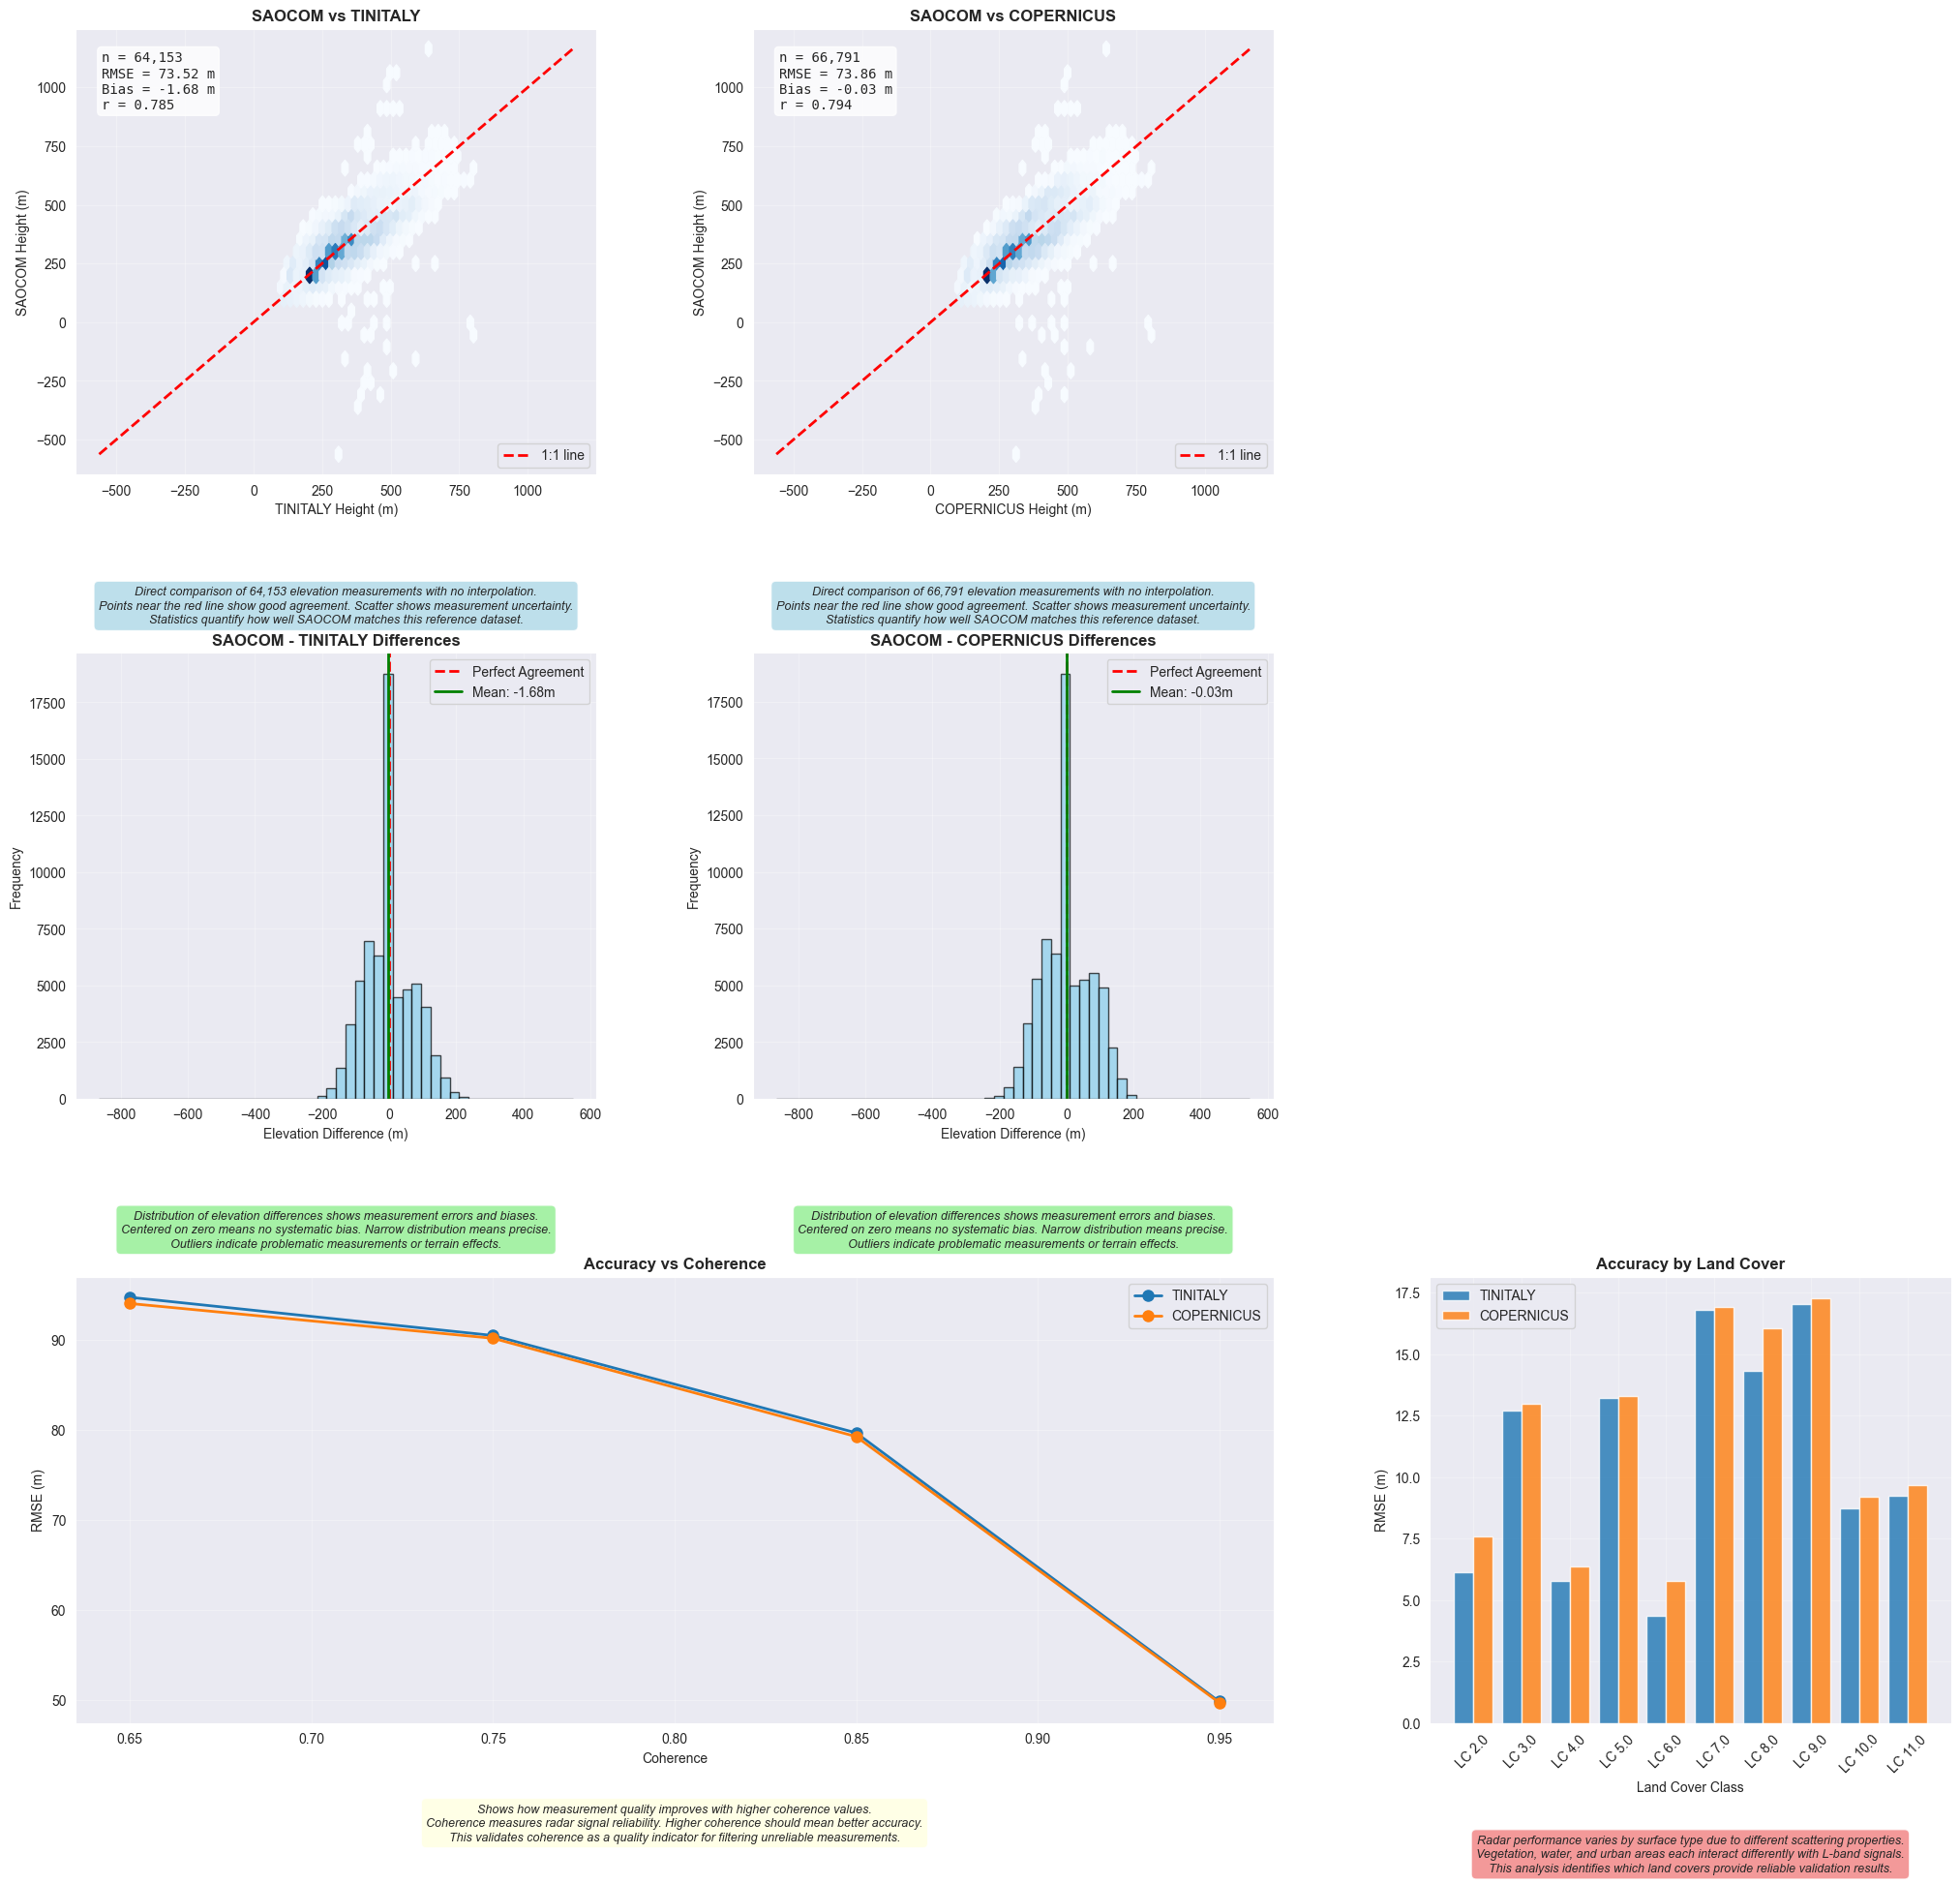


📋 Validation Summary Table
 Reference N Points Mean Error (m) RMSE (m) MAE (m) NMAD (m) LE95 (m) Correlation
  TINITALY   64,153          -1.68    73.52   55.62    71.88   140.49       0.785
COPERNICUS   66,791          -0.03    73.86   56.57    74.48   138.93       0.794

✅ Direct point validation complete!
📋 Ready for Cell 6: Coherence-Quality Relationships


In [65]:
# Cell 5: Direct Point Validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib_scalebar.scalebar import ScaleBar

print("📊 DIRECT POINT VALIDATION")
print("="*50)
print("Direct comparison of SAOCOM vs reference DEMs (NO INTERPOLATION)")

# ============================================================================
# 1. STATISTICAL METRICS FUNCTIONS
# ============================================================================
def calculate_error_metrics(observed, reference, name=""):
    """Calculate comprehensive error metrics"""
    # Remove NaN values
    mask = ~(np.isnan(observed) | np.isnan(reference))
    obs_clean = observed[mask]
    ref_clean = reference[mask]

    if len(obs_clean) == 0:
        return None

    # Calculate differences
    diff = obs_clean - ref_clean

    # Classical metrics
    me = np.mean(diff)  # Mean Error (bias)
    mae = np.mean(np.abs(diff))  # Mean Absolute Error
    rmse = np.sqrt(np.mean(diff**2))  # Root Mean Square Error
    std = np.std(diff)  # Standard deviation

    # Robust metrics
    median_error = np.median(diff)
    mad = np.median(np.abs(diff - median_error))  # Median Absolute Deviation
    nmad = 1.4826 * mad  # Normalized MAD (robust std estimate)

    # Percentile-based metrics
    le68 = np.percentile(np.abs(diff), 68.27)  # ~1 sigma
    le90 = np.percentile(np.abs(diff), 90)
    le95 = np.percentile(np.abs(diff), 95)

    # Correlation
    correlation = np.corrcoef(obs_clean, ref_clean)[0, 1]

    return {
        'name': name,
        'n_points': len(obs_clean),
        'mean_error': me,
        'mae': mae,
        'rmse': rmse,
        'std': std,
        'median_error': median_error,
        'nmad': nmad,
        'le68': le68,
        'le90': le90,
        'le95': le95,
        'correlation': correlation,
        'min_diff': diff.min(),
        'max_diff': diff.max()
    }

# ============================================================================
# 2. OVERALL VALIDATION STATISTICS
# ============================================================================
print("\n📈 Overall validation statistics...")

validation_results = {}

for ref in available_refs:
    ref_name = ref.replace('_height', '').upper()
    print(f"\n   SAOCOM vs {ref_name}:")

    metrics = calculate_error_metrics(
        master_df['saocom_height'].values,
        master_df[ref].values,
        name=f"SAOCOM vs {ref_name}"
    )

    if metrics:
        validation_results[ref_name] = metrics
        print(f"      Valid comparisons: {metrics['n_points']:,}")
        print(f"      Mean Error (bias): {metrics['mean_error']:.2f} m")
        print(f"      RMSE: {metrics['rmse']:.2f} m")
        print(f"      MAE: {metrics['mae']:.2f} m")
        print(f"      NMAD (robust): {metrics['nmad']:.2f} m")
        print(f"      LE95: {metrics['le95']:.2f} m")
        print(f"      Correlation: {metrics['correlation']:.3f}")
    else:
        print(f"      No valid comparisons available")

# ============================================================================
# 3. VALIDATION BY COHERENCE BINS
# ============================================================================
print("\n🎯 Validation by coherence bins...")

# Define coherence bins
coherence_bins = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
coherence_labels = [f"{coherence_bins[i]:.1f}-{coherence_bins[i+1]:.1f}"
                   for i in range(len(coherence_bins)-1)]

# Add coherence bin column
master_df['coherence_bin'] = pd.cut(master_df['coherence'],
                                   bins=coherence_bins,
                                   labels=coherence_labels,
                                   include_lowest=True)

coherence_results = {}

for ref in available_refs:
    ref_name = ref.replace('_height', '').upper()
    coherence_results[ref_name] = {}

    print(f"\n   {ref_name} by coherence:")

    for bin_label in coherence_labels:
        bin_data = master_df[master_df['coherence_bin'] == bin_label]

        if len(bin_data) > 10:  # Minimum 10 points for statistics
            metrics = calculate_error_metrics(
                bin_data['saocom_height'].values,
                bin_data[ref].values,
                name=f"{ref_name} coherence {bin_label}"
            )

            if metrics and metrics['n_points'] > 0:
                coherence_results[ref_name][bin_label] = metrics
                print(f"      {bin_label}: n={metrics['n_points']:,}, "
                      f"RMSE={metrics['rmse']:.2f}m, "
                      f"bias={metrics['mean_error']:.2f}m")

# ============================================================================
# 4. VALIDATION BY LAND COVER CLASS
# ============================================================================
if 'land_cover' in master_df.columns and not master_df['land_cover'].isna().all():
    print("\n🌱 Validation by land cover class...")

    landcover_results = {}

    # Get most common land cover classes (minimum 50 points)
    lc_counts = master_df['land_cover'].value_counts()
    common_lc = lc_counts[lc_counts >= 50].index

    for ref in available_refs:
        ref_name = ref.replace('_height', '').upper()
        landcover_results[ref_name] = {}

        print(f"\n   {ref_name} by land cover:")

        for lc_class in common_lc:
            lc_data = master_df[master_df['land_cover'] == lc_class]

            metrics = calculate_error_metrics(
                lc_data['saocom_height'].values,
                lc_data[ref].values,
                name=f"{ref_name} LC {lc_class}"
            )

            if metrics and metrics['n_points'] > 0:
                landcover_results[ref_name][lc_class] = metrics

                # Get land cover label if available
                if 'land_cover_label' in master_df.columns:
                    lc_label = lc_data['land_cover_label'].iloc[0]
                    label_text = f"{lc_class} ({lc_label})"
                else:
                    label_text = f"{lc_class}"

                print(f"      {label_text}: n={metrics['n_points']:,}, "
                      f"RMSE={metrics['rmse']:.2f}m, "
                      f"bias={metrics['mean_error']:.2f}m")

# ============================================================================
# 5. VISUALIZATION WITH EXPLANATIONS
# ============================================================================
print("\n📊 Creating validation visualizations...")

def add_scalebar(ax):
    """Add scale bar to map"""
    scalebar = ScaleBar(1, "m", location="lower right",
           color="black", box_color="white", box_alpha=0.8,
           pad=1.0, border_pad=0.5, sep=5,
           length_fraction=0.2, font_properties={'size': 10})
    ax.add_artist(scalebar)

# Create comprehensive validation plots
n_refs = len(available_refs)
if n_refs > 0:
    fig = plt.figure(figsize=(25, 25))

    # Create subplot layout based on number of references
    if n_refs == 1:
        gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3)
    elif n_refs == 2:
        gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
    else:
        gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

    plot_idx = 0

    # Plot scatter plots for each reference
    for i, ref in enumerate(available_refs):
        ref_name = ref.replace('_height', '').upper()

        # Scatter plot
        ax = fig.add_subplot(gs[0, i])

        # Get valid data
        valid_mask = master_df[['saocom_height', ref]].notna().all(axis=1)
        valid_data = master_df[valid_mask]

        if len(valid_data) > 0:
            # Create density scatter plot
            ax.hexbin(valid_data[ref], valid_data['saocom_height'],
                     gridsize=30, cmap='Blues', mincnt=1)

            # Add 1:1 line
            min_val = min(valid_data[ref].min(), valid_data['saocom_height'].min())
            max_val = max(valid_data[ref].max(), valid_data['saocom_height'].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')

            # Add statistics text
            if ref_name in validation_results:
                stats_text = f"n = {validation_results[ref_name]['n_points']:,}\n"
                stats_text += f"RMSE = {validation_results[ref_name]['rmse']:.2f} m\n"
                stats_text += f"Bias = {validation_results[ref_name]['mean_error']:.2f} m\n"
                stats_text += f"r = {validation_results[ref_name]['correlation']:.3f}"

                ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
                       verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

            ax.set_xlabel(f'{ref_name} Height (m)')
            ax.set_ylabel('SAOCOM Height (m)')
            ax.set_title(f'SAOCOM vs {ref_name}', fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()

            # Explanation
            ax.text(0.5, -0.25, f'Direct comparison of {len(valid_data):,} elevation measurements with no interpolation.\nPoints near the red line show good agreement. Scatter shows measurement uncertainty.\nStatistics quantify how well SAOCOM matches this reference dataset.',
                   transform=ax.transAxes, ha='center', va='top',
                   fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8))

    # Difference histograms
    for i, ref in enumerate(available_refs):
        ref_name = ref.replace('_height', '').upper()
        diff_col = f'diff_{ref.replace("_height", "")}'

        if diff_col in master_df.columns:
            ax = fig.add_subplot(gs[1, i])

            valid_diffs = master_df[diff_col].dropna()

            if len(valid_diffs) > 0:
                # Histogram
                ax.hist(valid_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
                ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Agreement')
                ax.axvline(valid_diffs.mean(), color='green', linestyle='-', linewidth=2,
                          label=f'Mean: {valid_diffs.mean():.2f}m')

                ax.set_xlabel('Elevation Difference (m)')
                ax.set_ylabel('Frequency')
                ax.set_title(f'SAOCOM - {ref_name} Differences', fontweight='bold')
                ax.legend()
                ax.grid(True, alpha=0.3)

                # Explanation
                ax.text(0.5, -0.25, f'Distribution of elevation differences shows measurement errors and biases.\nCentered on zero means no systematic bias. Narrow distribution means precise.\nOutliers indicate problematic measurements or terrain effects.',
                       transform=ax.transAxes, ha='center', va='top',
                       fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))

    # Coherence analysis plot
    if len(coherence_results) > 0:
        ax = fig.add_subplot(gs[2, :2])

        # Plot RMSE vs coherence for each reference
        for ref_name in coherence_results:
            coherence_vals = []
            rmse_vals = []

            for bin_label, metrics in coherence_results[ref_name].items():
                coherence_center = float(bin_label.split('-')[0]) + 0.05  # Bin center
                coherence_vals.append(coherence_center)
                rmse_vals.append(metrics['rmse'])

            if coherence_vals:
                ax.plot(coherence_vals, rmse_vals, 'o-', linewidth=2, markersize=8, label=ref_name)

        ax.set_xlabel('Coherence')
        ax.set_ylabel('RMSE (m)')
        ax.set_title('Accuracy vs Coherence', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Explanation
        ax.text(0.5, -0.18, 'Shows how measurement quality improves with higher coherence values.\nCoherence measures radar signal reliability. Higher coherence should mean better accuracy.\nThis validates coherence as a quality indicator for filtering unreliable measurements.',
               transform=ax.transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.8))

    # Land cover analysis plot
    if len(landcover_results) > 0 and any(landcover_results.values()):
        ax = fig.add_subplot(gs[2, 2:])

        # Get common land cover classes across all references
        all_lc_classes = set()
        for ref_results in landcover_results.values():
            all_lc_classes.update(ref_results.keys())

        common_lc_classes = sorted(list(all_lc_classes))[:10]  # Top 10

        x_pos = np.arange(len(common_lc_classes))
        width = 0.8 / len(landcover_results)

        for i, ref_name in enumerate(landcover_results):
            rmse_vals = []
            for lc_class in common_lc_classes:
                if lc_class in landcover_results[ref_name]:
                    rmse_vals.append(landcover_results[ref_name][lc_class]['rmse'])
                else:
                    rmse_vals.append(np.nan)

            # Remove NaN values for plotting
            valid_x = [x for x, rmse in zip(x_pos, rmse_vals) if not np.isnan(rmse)]
            valid_rmse = [rmse for rmse in rmse_vals if not np.isnan(rmse)]

            if valid_x:
                ax.bar([x + i*width for x in valid_x], valid_rmse, width,
                      label=ref_name, alpha=0.8)

        ax.set_xlabel('Land Cover Class')
        ax.set_ylabel('RMSE (m)')
        ax.set_title('Accuracy by Land Cover', fontweight='bold')
        ax.set_xticks([x + width/2 for x in x_pos])
        ax.set_xticklabels([f'LC {lc}' for lc in common_lc_classes], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Explanation
        ax.text(0.5, -0.25, 'Radar performance varies by surface type due to different scattering properties.\nVegetation, water, and urban areas each interact differently with L-band signals.\nThis analysis identifies which land covers provide reliable validation results.',
               transform=ax.transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18, hspace=0.5, wspace=0.35)
    plt.savefig(RESULTS_DIR / 'direct_point_validation.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 6. SUMMARY TABLE
# ============================================================================
print("\n📋 Validation Summary Table")
print("="*80)

if validation_results:
    # Create summary DataFrame
    summary_data = []
    for ref_name, metrics in validation_results.items():
        summary_data.append({
            'Reference': ref_name,
            'N Points': f"{metrics['n_points']:,}",
            'Mean Error (m)': f"{metrics['mean_error']:+.2f}",
            'RMSE (m)': f"{metrics['rmse']:.2f}",
            'MAE (m)': f"{metrics['mae']:.2f}",
            'NMAD (m)': f"{metrics['nmad']:.2f}",
            'LE95 (m)': f"{metrics['le95']:.2f}",
            'Correlation': f"{metrics['correlation']:.3f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    # Save summary table
    summary_df.to_csv(RESULTS_DIR / 'validation_summary_table.csv', index=False)

# Store results for next cells
point_validation_results = {
    'validation_results': validation_results,
    'coherence_results': coherence_results,
    'landcover_results': landcover_results if 'land_cover' in master_df.columns else {},
    'master_df': master_df,
    'available_refs': available_refs
}

print(f"\n✅ Direct point validation complete!")
print(f"📋 Ready for Cell 6: Coherence-Quality Relationships")



📊 Creating density visualizations...


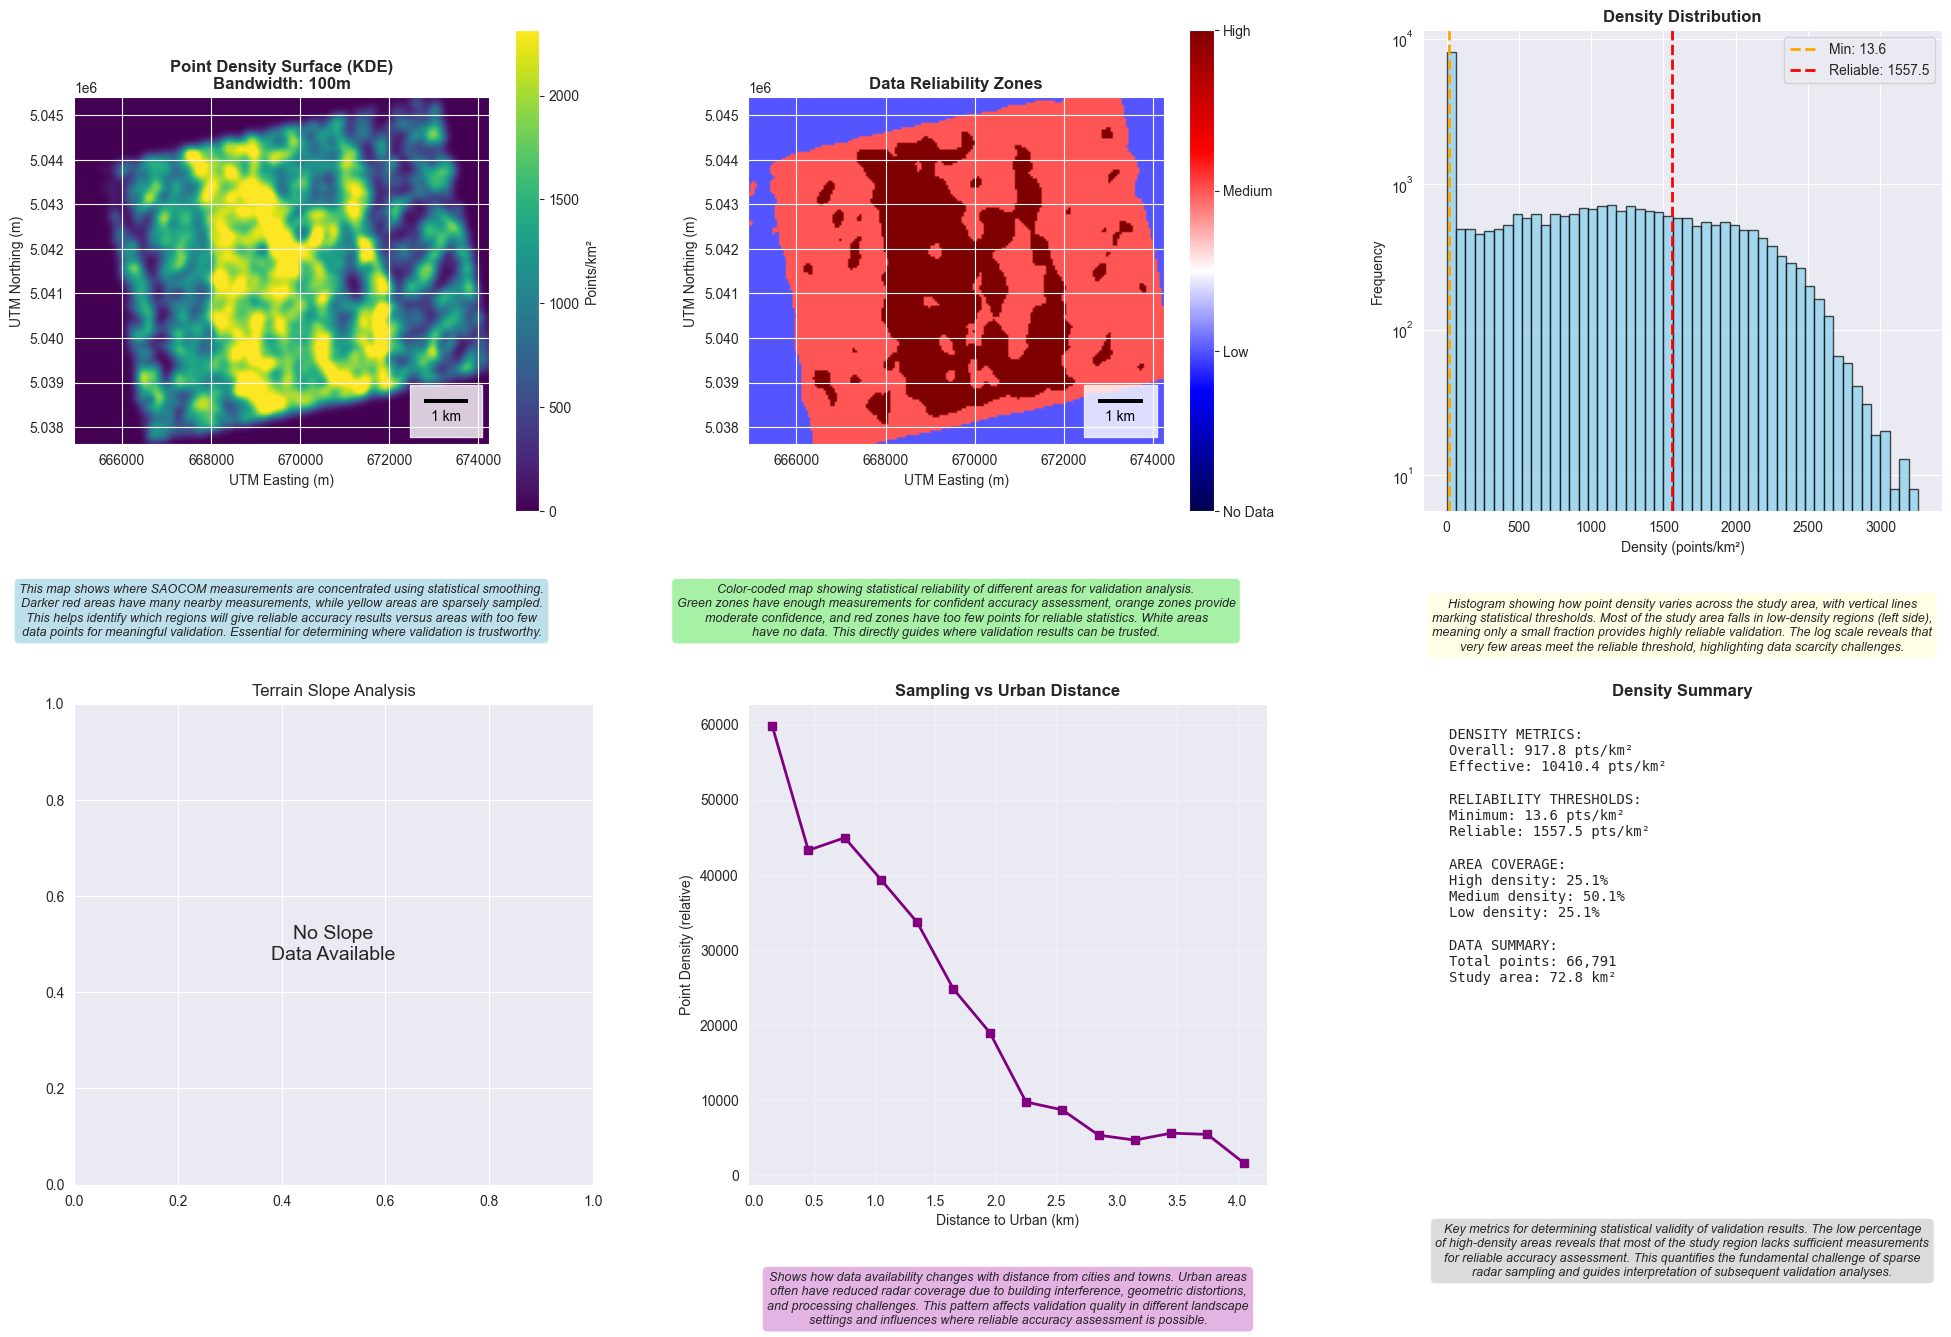

In [66]:
# ============================================================================
# 7. VISUALIZATION WITH DETAILED EXPLANATIONS
# ============================================================================
print("\n📊 Creating density visualizations...")

def add_scalebar(ax):
    """Add scale bar to map"""
    scalebar = ScaleBar(1, "m", location="lower right",
           color="black", box_color="white", box_alpha=0.8,
           pad=1.0, border_pad=0.5, sep=5,
           length_fraction=0.2, font_properties={'size': 10})
    ax.add_artist(scalebar)

fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# Plot 1: KDE density surface
im1 = axes[0,0].imshow(kde_density_km2, extent=[xmin, xmax, ymin, ymax],
                       cmap='viridis', origin='lower', vmax=np.percentile(kde_density_km2, 95))

axes[0,0].set_title(f'Point Density Surface (KDE)\nBandwidth: {bandwidth}m', fontweight='bold')
axes[0,0].set_xlabel('UTM Easting (m)')
axes[0,0].set_ylabel('UTM Northing (m)')
plt.colorbar(im1, ax=axes[0,0], label='Points/km²')
add_scalebar(axes[0,0])
axes[0,0].text(0.5, -0.4, 'This map shows where SAOCOM measurements are concentrated using statistical smoothing.\nDarker red areas have many nearby measurements, while yellow areas are sparsely sampled.\nThis helps identify which regions will give reliable accuracy results versus areas with too few\ndata points for meaningful validation. Essential for determining where validation is trustworthy.',
               transform=axes[0,0].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8))

# Plot 2: Density reliability classes
density_classes = np.zeros_like(kde_density_km2)
density_classes[kde_density_km2 >= reliable_threshold] = 3
density_classes[(kde_density_km2 >= min_threshold) & (kde_density_km2 < reliable_threshold)] = 2
density_classes[(kde_density_km2 > 0) & (kde_density_km2 < min_threshold)] = 1

from matplotlib.colors import ListedColormap
reliability_colors = ['#FFFFFF', '#D55E00', '#E69F00', '#009E73']  # White, Red, Orange, Green
reliability_cmap = ListedColormap(reliability_colors)


im2 = axes[0,1].imshow(density_classes, extent=[xmin, xmax, ymin, ymax],
                       cmap='seismic', origin='lower', vmin=0, vmax=3)
axes[0,1].set_title('Data Reliability Zones', fontweight='bold')
axes[0,1].set_xlabel('UTM Easting (m)')
axes[0,1].set_ylabel('UTM Northing (m)')
cbar2 = plt.colorbar(im2, ax=axes[0,1])
cbar2.set_ticks([0, 1, 2, 3])
cbar2.set_ticklabels(['No Data', 'Low', 'Medium', 'High'])
add_scalebar(axes[0,1])
axes[0,1].text(0.5, -0.4, 'Color-coded map showing statistical reliability of different areas for validation analysis.\nGreen zones have enough measurements for confident accuracy assessment, orange zones provide\nmoderate confidence, and red zones have too few points for reliable statistics. White areas\nhave no data. This directly guides where validation results can be trusted.',
               transform=axes[0,1].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.8))

# Plot 3: Density distribution histogram
axes[0,2].hist(kde_density_km2[kde_density_km2 > 0].ravel(), bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,2].axvline(min_threshold, color='orange', linestyle='--', linewidth=2, label=f'Min: {min_threshold:.1f}')
axes[0,2].axvline(reliable_threshold, color='red', linestyle='--', linewidth=2, label=f'Reliable: {reliable_threshold:.1f}')
axes[0,2].set_xlabel('Density (points/km²)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Density Distribution', fontweight='bold')
axes[0,2].legend()
axes[0,2].set_yscale('log')
axes[0,2].text(0.5, -0.18, 'Histogram showing how point density varies across the study area, with vertical lines\nmarking statistical thresholds. Most of the study area falls in low-density regions (left side),\nmeaning only a small fraction provides highly reliable validation. The log scale reveals that\nvery few areas meet the reliable threshold, highlighting data scarcity challenges.',
               transform=axes[0,2].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.8))

# Plot 4: Terrain slope analysis
if 'slope' in saocom_gdf.columns and not saocom_gdf['slope'].isna().all():
    valid_slope = saocom_gdf.dropna(subset=['slope'])

    # Create slope vs density scatter
    slope_bins = np.linspace(0, valid_slope['slope'].max(), 20)
    density_by_slope = []
    slope_centers = []

    for i in range(len(slope_bins)-1):
        mask = (valid_slope['slope'] >= slope_bins[i]) & (valid_slope['slope'] < slope_bins[i+1])
        if mask.sum() > 0:
            density_by_slope.append(mask.sum() / ((slope_bins[i+1] - slope_bins[i]) * study_area_km2 / 100))
            slope_centers.append((slope_bins[i] + slope_bins[i+1]) / 2)

    axes[1,0].plot(slope_centers, density_by_slope, 'o-', color='brown', linewidth=2, markersize=6)
    axes[1,0].set_xlabel('Slope (degrees)')
    axes[1,0].set_ylabel('Point Density (relative)')
    axes[1,0].set_title('Sampling vs Terrain Slope', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].text(0.5, -0.18, 'This graph reveals how L-band radar performs on different terrain types. Radar waves\nstruggle on steep slopes due to geometric distortions and shadowing effects, while flat\nareas provide better signal return. The pattern shows where terrain limits radar\ncoverage, helping explain why some areas lack measurements.',
               transform=axes[1,0].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))
else:
    axes[1,0].text(0.5, 0.5, 'No Slope\nData Available', ha='center', va='center',
                   transform=axes[1,0].transAxes, fontsize=14)
    axes[1,0].set_title('Terrain Slope Analysis')

# Plot 5: Urban distance analysis
if 'dist_to_urban_km' in saocom_gdf.columns and not saocom_gdf['dist_to_urban_km'].isna().all():
    valid_urban = saocom_gdf.dropna(subset=['dist_to_urban_km'])

    # Urban distance vs density
    dist_bins = np.linspace(0, valid_urban['dist_to_urban_km'].max(), 15)
    density_by_distance = []
    dist_centers = []

    for i in range(len(dist_bins)-1):
        mask = (valid_urban['dist_to_urban_km'] >= dist_bins[i]) & (valid_urban['dist_to_urban_km'] < dist_bins[i+1])
        if mask.sum() > 0:
            density_by_distance.append(mask.sum() / ((dist_bins[i+1] - dist_bins[i]) * study_area_km2 / 100))
            dist_centers.append((dist_bins[i] + dist_bins[i+1]) / 2)

    axes[1,1].plot(dist_centers, density_by_distance, 's-', color='purple', linewidth=2, markersize=6)
    axes[1,1].set_xlabel('Distance to Urban (km)')
    axes[1,1].set_ylabel('Point Density (relative)')
    axes[1,1].set_title('Sampling vs Urban Distance', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].text(0.5, -0.18, 'Shows how data availability changes with distance from cities and towns. Urban areas\noften have reduced radar coverage due to building interference, geometric distortions,\nand processing challenges. This pattern affects validation quality in different landscape\nsettings and influences where reliable accuracy assessment is possible.',
               transform=axes[1,1].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="plum", alpha=0.8))
else:
    axes[1,1].text(0.5, 0.5, 'No Urban\nData Available', ha='center', va='center',
                   transform=axes[1,1].transAxes, fontsize=14)
    axes[1,1].set_title('Urban Distance Analysis')

# Plot 6: Summary statistics with coverage metrics
summary_text = [
    f"DENSITY METRICS:",
    f"Overall: {overall_density:.1f} pts/km²",
    f"Effective: {effective_density:.1f} pts/km²",
    f"",
    f"RELIABILITY THRESHOLDS:",
    f"Minimum: {min_threshold:.1f} pts/km²",
    f"Reliable: {reliable_threshold:.1f} pts/km²",
    f"",
    f"AREA COVERAGE:",
    f"High density: {100*high_density_area/study_area_km2:.1f}%",
    f"Medium density: {100*medium_density_area/study_area_km2:.1f}%",
    f"Low density: {100*low_density_area/study_area_km2:.1f}%",
    f"",
    f"DATA SUMMARY:",
    f"Total points: {len(saocom_gdf):,}",
    f"Study area: {study_area_km2:.1f} km²"
]

axes[1,2].text(0.05, 0.95, '\n'.join(summary_text), transform=axes[1,2].transAxes,
               verticalalignment='top', fontfamily='monospace', fontsize=10)
axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)
axes[1,2].axis('off')
axes[1,2].set_title('Density Summary', fontweight='bold')
axes[1,2].text(0.5, -0.08, 'Key metrics for determining statistical validity of validation results. The low percentage\nof high-density areas reveals that most of the study region lacks sufficient measurements\nfor reliable accuracy assessment. This quantifies the fundamental challenge of sparse\nradar sampling and guides interpretation of subsequent validation analyses.',
               transform=axes[1,2].transAxes, ha='center', va='top',
               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=0.4, wspace=0.3)
plt.savefig(RESULTS_DIR / 'point_density_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


📊 Generating void distribution maps...


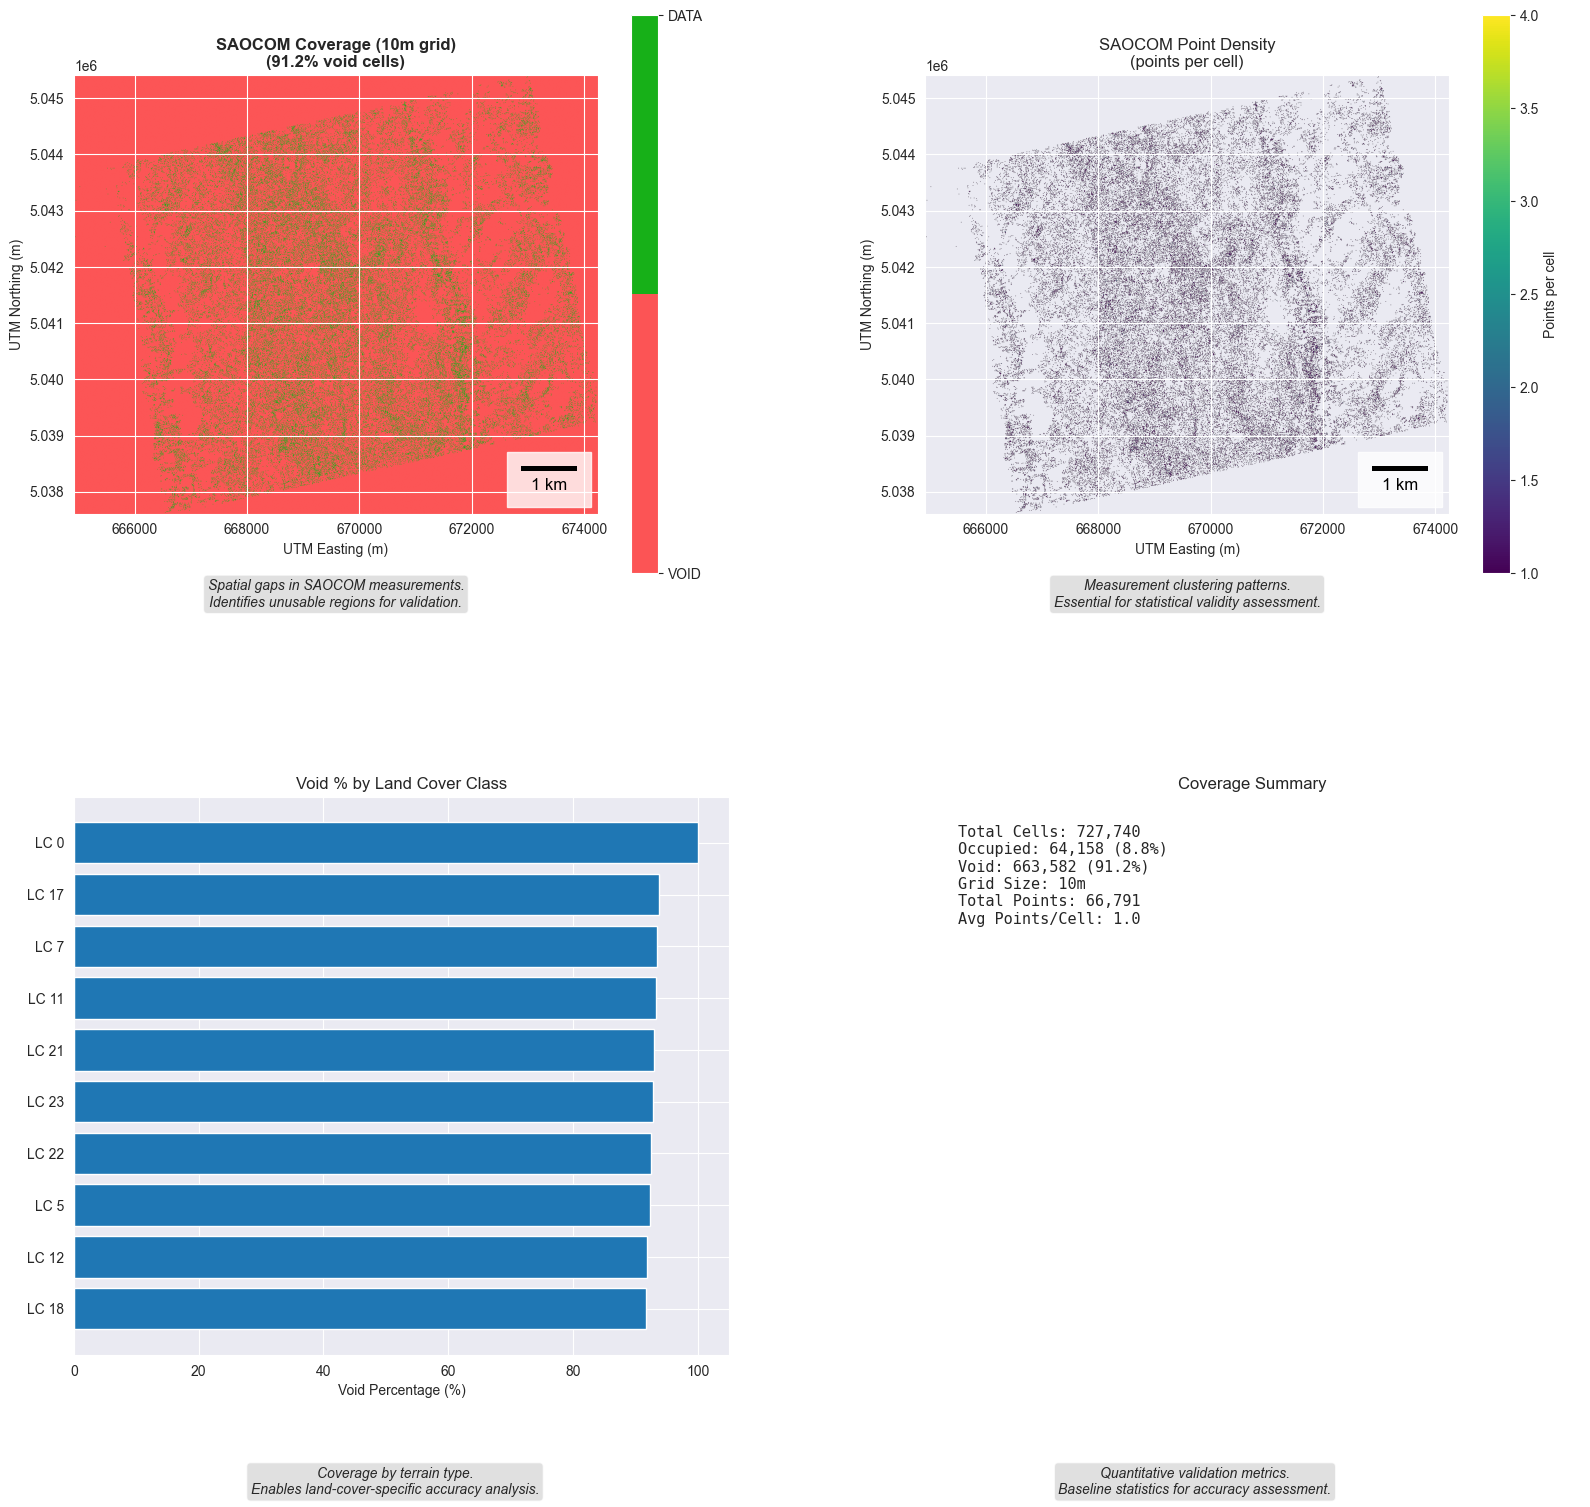


📋 COVERAGE ANALYSIS SUMMARY
Grid Resolution: 10m
Total Study Area: 727,740 cells (72.8 km²)
SAOCOM Coverage: 64,158 cells (8.8%)
Void Areas: 663,582 cells (91.2%)
Point Density: 1.0 points/occupied cell

✅ Coverage analysis complete!
📋 Ready for Cell 3: Point Density Analysis


In [67]:
# ============================================================================
# 6. GENERATE VOID DISTRIBUTION MAPS
# ============================================================================
print("\n📊 Generating void distribution maps...")
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
def add_scalebar(ax):
    scalebar = ScaleBar(1, "m", location="lower right",
           color="black", box_color="white", box_alpha=0.8,
           pad=1.0, border_pad=0.5, sep=5,
           length_fraction=0.2, font_properties={'size': 12})
    ax.add_artist(scalebar)
# Reshape data for plotting
custom_colors = ['#FF4444', '#00AA00']  # Red for void, Green for data
has_saocom_grid = grid_df['has_saocom'].values.reshape(grid_x.shape)
n_points_grid = grid_df['n_saocom_points'].values.reshape(grid_x.shape)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
binary_cmap = ListedColormap(custom_colors)
# Plot 1: Void/Occupied cells
im1 = axes[0,0].imshow(has_saocom_grid, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid],
                       cmap=binary_cmap, alpha=0.9, origin='lower', vmin=0, vmax=1)
axes[0,0].set_title(f'SAOCOM Coverage (10m grid)\n({void_percentage:.1f}% void cells)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('UTM Easting (m)')
axes[0,0].set_ylabel('UTM Northing (m)')
cbar1 = plt.colorbar(im1, ax=axes[0,0])
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(['VOID', 'DATA'])
add_scalebar(axes[0,0])
axes[0,0].text(0.5, -0.15, 'Spatial gaps in SAOCOM measurements.\nIdentifies unusable regions for validation.',
               transform=axes[0,0].transAxes, ha='center', va='top',
               fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))


# Plot 2: Point density
masked_points = np.where(has_saocom_grid, n_points_grid, np.nan)
im2 = axes[0,1].imshow(masked_points, extent=[xmin_grid, xmax_grid, ymin_grid, ymax_grid],
                       cmap='viridis', origin='lower')
axes[0,1].set_title('SAOCOM Point Density\n(points per cell)')
axes[0,1].set_xlabel('UTM Easting (m)')
axes[0,1].set_ylabel('UTM Northing (m)')
plt.colorbar(im2, ax=axes[0,1], label='Points per cell')
add_scalebar(axes[0,1])
axes[0,1].text(0.5, -0.15, 'Measurement clustering patterns.\nEssential for statistical validity assessment.',
               transform=axes[0,1].transAxes, ha='center', va='top',
               fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

# Plot 3: Void percentage histogram by land cover (if available)
if 'land_cover' in grid_df.columns and not grid_df['land_cover'].isna().all():
    lc_stats = grid_df.groupby('land_cover')['has_saocom'].agg(['count', 'sum'])
    lc_stats['void_pct'] = 100 * (lc_stats['count'] - lc_stats['sum']) / lc_stats['count']
    lc_stats = lc_stats.sort_values('void_pct', ascending=True).tail(10)

    axes[1,0].barh(range(len(lc_stats)), lc_stats['void_pct'])
    axes[1,0].set_yticks(range(len(lc_stats)))
    axes[1,0].set_yticklabels([f'LC {int(idx)}' for idx in lc_stats.index])
    axes[1,0].set_xlabel('Void Percentage (%)')
    axes[1,0].set_title('Void % by Land Cover Class')
else:
    axes[1,0].text(0.5, 0.5, 'No Land Cover\nData Available',
                   ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Land Cover Analysis')

# Plot 4: Coverage summary statistics
coverage_stats = [
    f"Total Cells: {n_total_cells:,}",
    f"Occupied: {n_occupied_cells:,} ({100*n_occupied_cells/n_total_cells:.1f}%)",
    f"Void: {n_void_cells:,} ({void_percentage:.1f}%)",
    f"Grid Size: {GRID_SIZE}m",
    f"Total Points: {len(saocom_gdf):,}",
    f"Avg Points/Cell: {saocom_gdf.shape[0]/n_occupied_cells:.1f}" if n_occupied_cells > 0 else "No occupied cells"
]

axes[1,1].text(0.05, 0.95, '\n'.join(coverage_stats),
               transform=axes[1,1].transAxes, verticalalignment='top',
               fontfamily='monospace', fontsize=11)
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].axis('off')
axes[1,1].set_title('Coverage Summary')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=0.4, wspace=0.3)  # More space

# NOW add blurbs in the bottom margin (outside plots)
fig.text(0.25, 0.08, 'Coverage by terrain type.\nEnables land-cover-specific accuracy analysis.',
         ha='center', va='top', fontsize=10, style='italic',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

fig.text(0.75, 0.08, 'Quantitative validation metrics.\nBaseline statistics for accuracy assessment.',
         ha='center', va='top', fontsize=10, style='italic',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.savefig(RESULTS_DIR / 'saocom_coverage_analysis_10m.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 7. SUMMARY STATISTICS
# ============================================================================
print(f"\n📋 COVERAGE ANALYSIS SUMMARY")
print("="*40)
print(f"Grid Resolution: {GRID_SIZE}m")
print(f"Total Study Area: {n_total_cells:,} cells ({n_total_cells * (GRID_SIZE/1000)**2:.1f} km²)")
print(f"SAOCOM Coverage: {n_occupied_cells:,} cells ({100*n_occupied_cells/n_total_cells:.1f}%)")
print(f"Void Areas: {n_void_cells:,} cells ({void_percentage:.1f}%)")
print(f"Point Density: {len(saocom_gdf)/n_occupied_cells:.1f} points/occupied cell")

# Store results for next cells
coverage_analysis = {
    'grid_df': grid_df,
    'grid_size': GRID_SIZE,
    'grid_bounds': (xmin_grid, ymin_grid, xmax_grid, ymax_grid),
    'void_percentage': void_percentage,
    'n_total_cells': n_total_cells,
    'n_occupied_cells': n_occupied_cells,
    'n_void_cells': n_void_cells
}

print(f"\n✅ Coverage analysis complete!")
print(f"📋 Ready for Cell 3: Point Density Analysis")

🔍 REFERENCE DATASET CROSS-VALIDATION
Direct comparison: TINITALY vs Copernicus (pixel-by-pixel)

📊 Loading reference DEMs...
   TINITALY: tinitaly_crop_10m_resampled.tif
   Copernicus: copernicus_10m_resampled.tif
   TINITALY shape: (777, 929)
   Copernicus shape: (777, 929)
   Transform match: True
   Bounds match: True

🧮 Calculating pixel-by-pixel differences...
   Total pixels: 721,833
   Valid comparisons: 656,620 (91.0%)
   Elevation range - TINITALY: 92.8 to 831.8 m
   Elevation range - Copernicus: 93.8 to 833.8 m

📈 Reference comparison statistics...
   Mean difference (TINITALY - Copernicus): -2.01 m
   Median difference: -0.62 m
   RMSE: 4.64 m
   MAE: 2.83 m
   NMAD (robust): 2.22 m
   LE95: 11.02 m
   Standard deviation: 4.19 m
   Correlation: 0.9995
   Range: -43.3 to +15.5 m

   Difference percentiles (m):
      1th: -16.75
      5th: -11.01
     10th:  -7.99
     25th:  -3.14
     50th:  -0.62
     75th:  +0.54
     90th:  +1.49
     95th:  +2.09
     99th:  +3.42

🎯 Agr

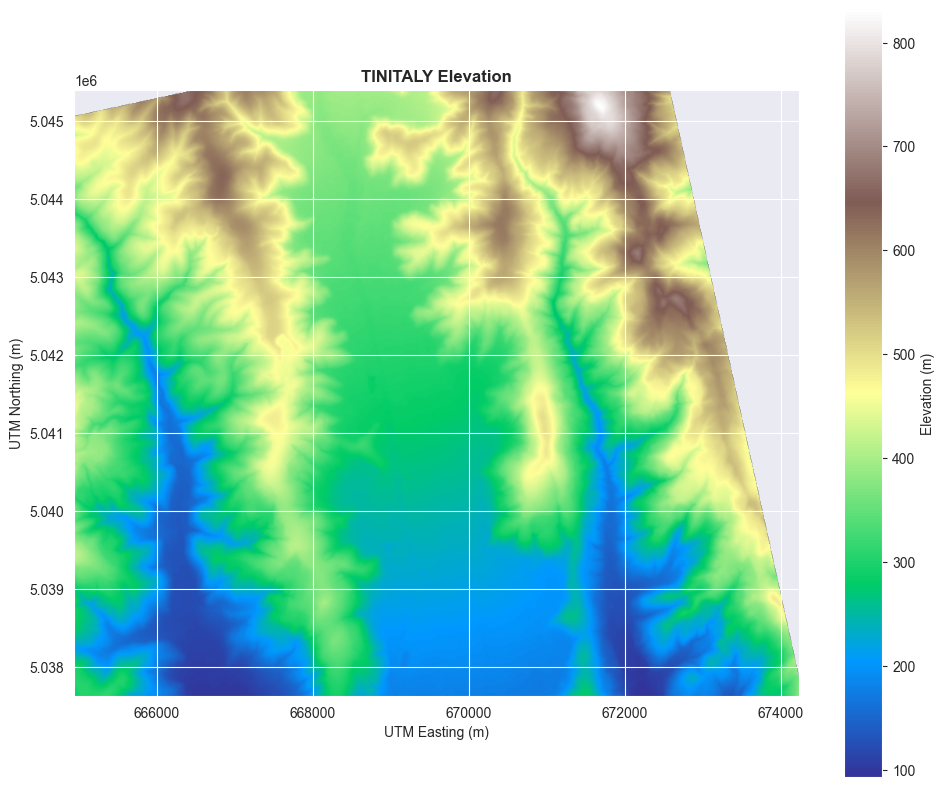

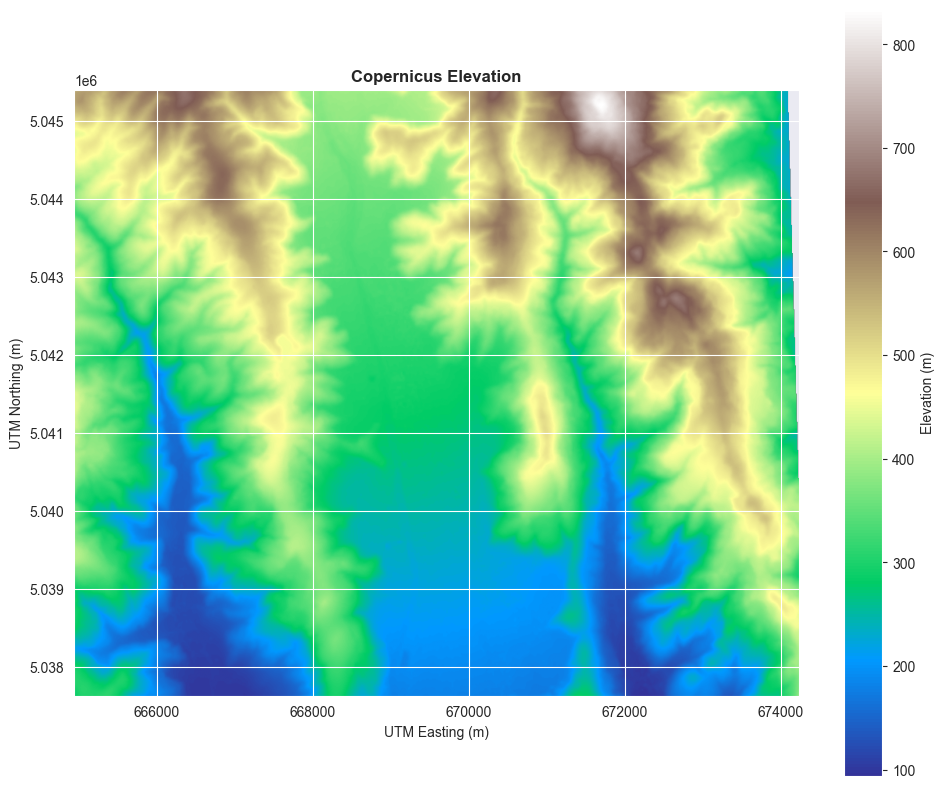

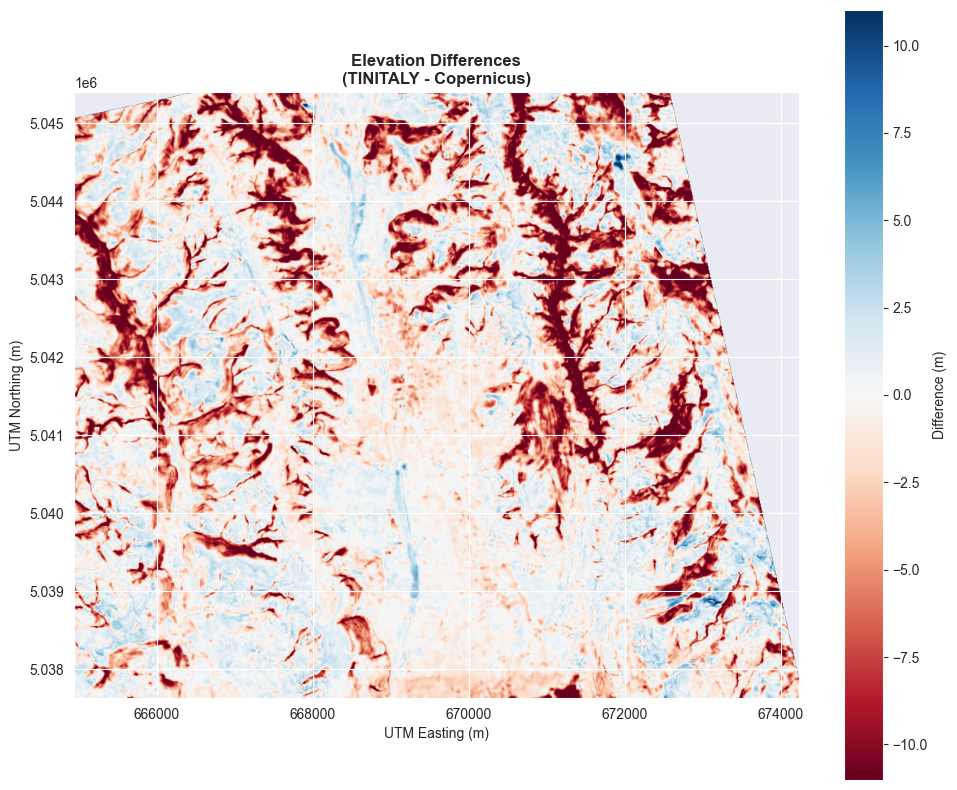

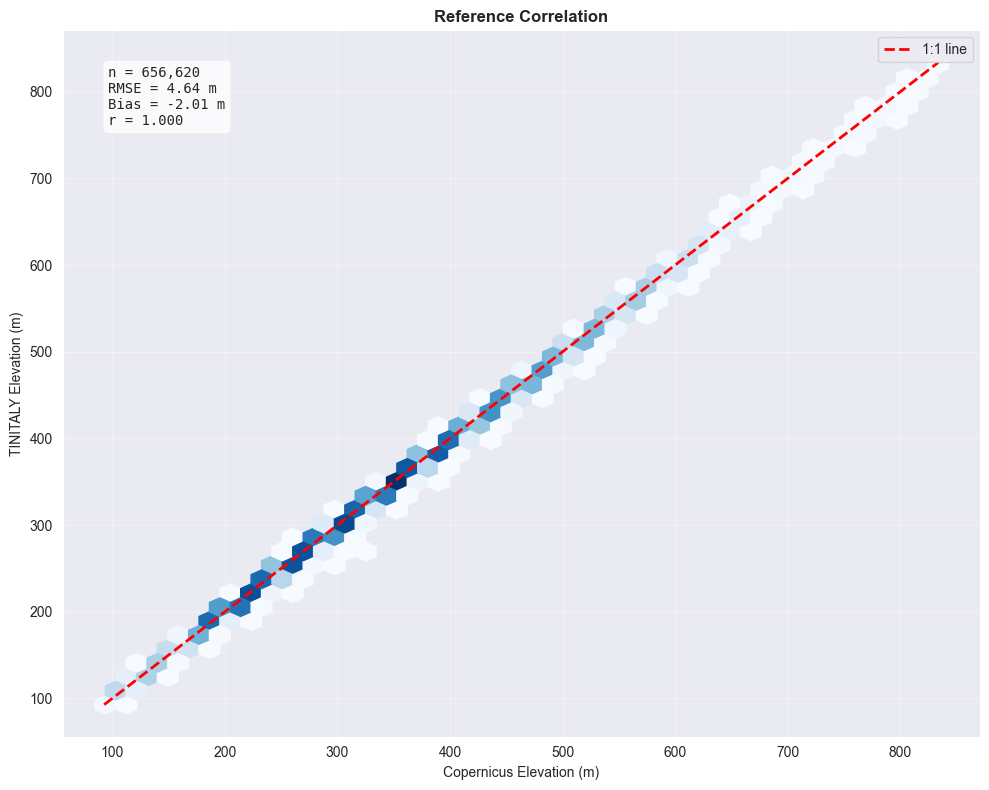

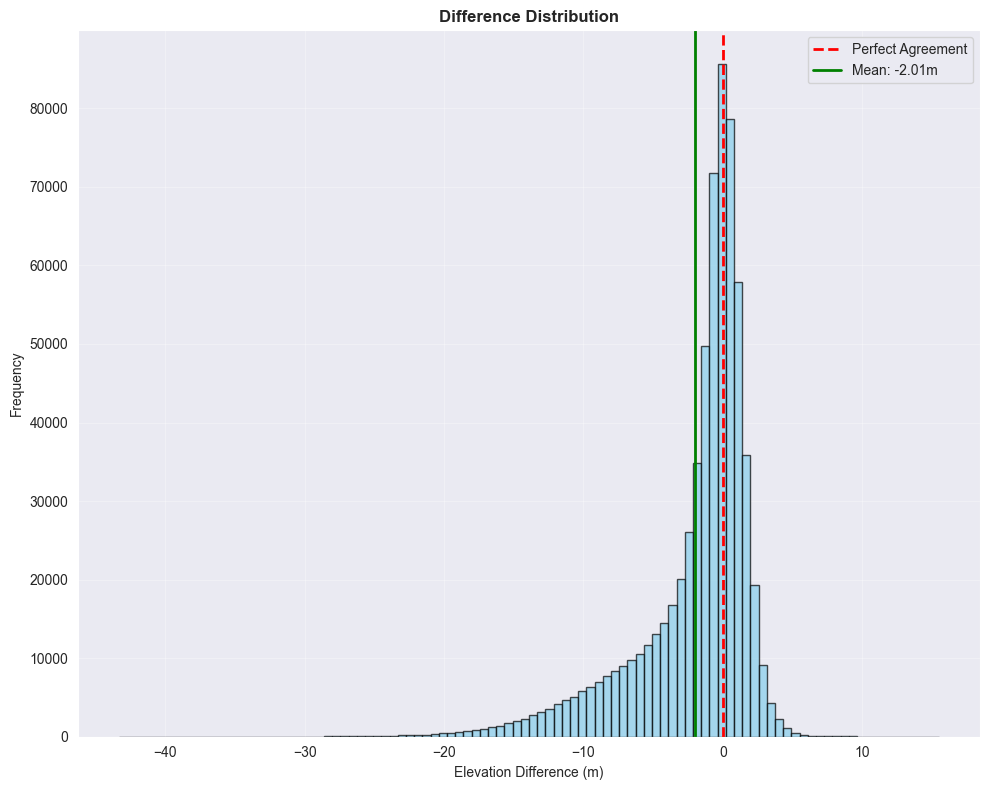

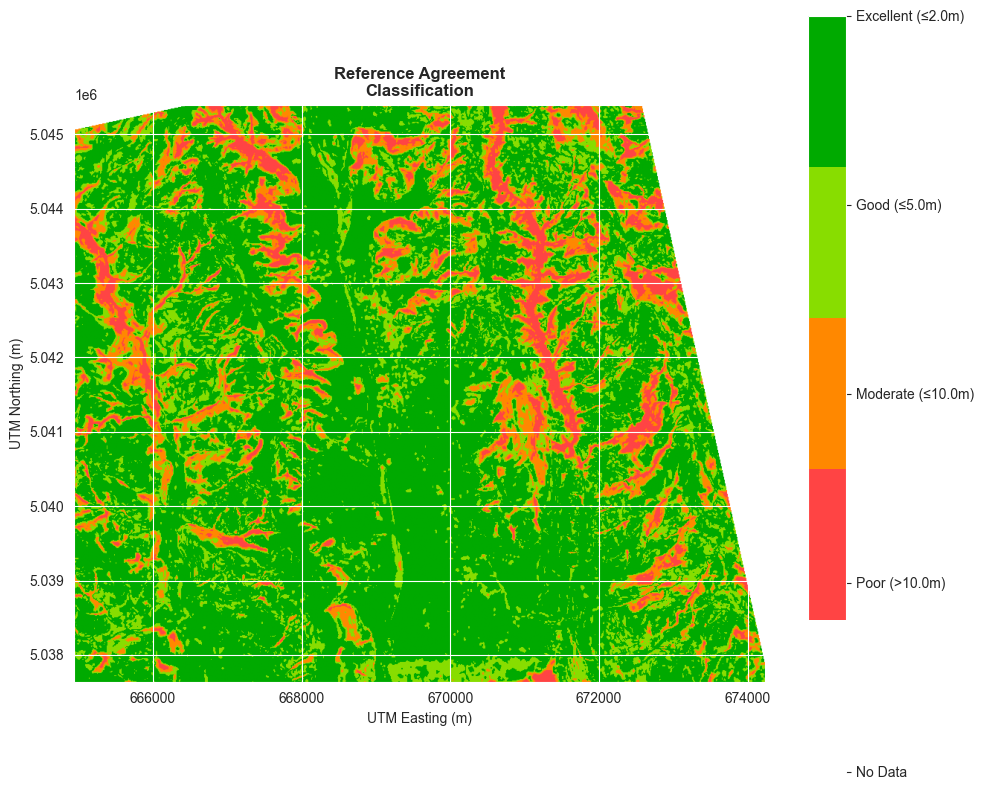


💾 Saving reference comparison results...


In [77]:
# Cell 6: Reference Dataset Cross-Validation
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats
import seaborn as sns

print("🔍 REFERENCE DATASET CROSS-VALIDATION")
print("="*50)
print("Direct comparison: TINITALY vs Copernicus (pixel-by-pixel)")

# ============================================================================
# 1. LOAD REFERENCE DEMS AND ENSURE ALIGNMENT
# ============================================================================
print("\n📊 Loading reference DEMs...")

if 'tinitaly_crop' in reference_dems and 'copernicus' in reference_dems:
    tinitaly_path = reference_dems['tinitaly_crop']['resampled_path']
    copernicus_path = reference_dems['copernicus']['resampled_path']

    print(f"   TINITALY: {tinitaly_path.name}")
    print(f"   Copernicus: {copernicus_path.name}")

    # Load both DEMs
    with rasterio.open(tinitaly_path) as src1:
        tinitaly_data = src1.read(1).astype(float)
        tinitaly_data[tinitaly_data == src1.nodata] = np.nan
        tinitaly_transform = src1.transform
        tinitaly_bounds = src1.bounds

    with rasterio.open(copernicus_path) as src2:
        copernicus_data = src2.read(1).astype(float)
        copernicus_data[copernicus_data == src2.nodata] = np.nan
        copernicus_transform = src2.transform
        copernicus_bounds = src2.bounds

    # Verify alignment
    print(f"   TINITALY shape: {tinitaly_data.shape}")
    print(f"   Copernicus shape: {copernicus_data.shape}")
    print(f"   Transform match: {tinitaly_transform == copernicus_transform}")
    print(f"   Bounds match: {tinitaly_bounds == copernicus_bounds}")

    if tinitaly_data.shape != copernicus_data.shape:
        print("   ⚠️  Shapes don't match - cropping to common area")
        min_rows = min(tinitaly_data.shape[0], copernicus_data.shape[0])
        min_cols = min(tinitaly_data.shape[1], copernicus_data.shape[1])
        tinitaly_data = tinitaly_data[:min_rows, :min_cols]
        copernicus_data = copernicus_data[:min_rows, :min_cols]
        print(f"   Cropped to: {tinitaly_data.shape}")

else:
    print("   ❌ Both reference DEMs required - skipping cross-validation")
    exit()

# ============================================================================
# 2. PIXEL-BY-PIXEL DIFFERENCE CALCULATION
# ============================================================================
print("\n🧮 Calculating pixel-by-pixel differences...")

# Calculate difference (TINITALY - Copernicus)
elevation_diff = tinitaly_data - copernicus_data

# Find valid pixels (both DEMs have data)
valid_mask = ~(np.isnan(tinitaly_data) | np.isnan(copernicus_data))
valid_pixels = np.sum(valid_mask)
total_pixels = tinitaly_data.size

print(f"   Total pixels: {total_pixels:,}")
print(f"   Valid comparisons: {valid_pixels:,} ({100*valid_pixels/total_pixels:.1f}%)")

if valid_pixels == 0:
    print("   ❌ No overlapping valid data found")
    exit()

# Extract valid differences for statistics
valid_diffs = elevation_diff[valid_mask]
valid_tinitaly = tinitaly_data[valid_mask]
valid_copernicus = copernicus_data[valid_mask]

print(f"   Elevation range - TINITALY: {valid_tinitaly.min():.1f} to {valid_tinitaly.max():.1f} m")
print(f"   Elevation range - Copernicus: {valid_copernicus.min():.1f} to {valid_copernicus.max():.1f} m")

# ============================================================================
# 3. COMPREHENSIVE REFERENCE COMPARISON STATISTICS
# ============================================================================
print("\n📈 Reference comparison statistics...")

# Calculate comprehensive metrics
ref_metrics = {
    'n_pixels': valid_pixels,
    'mean_diff': np.mean(valid_diffs),
    'median_diff': np.median(valid_diffs),
    'std_diff': np.std(valid_diffs),
    'rmse': np.sqrt(np.mean(valid_diffs**2)),
    'mae': np.mean(np.abs(valid_diffs)),
    'mad': np.median(np.abs(valid_diffs - np.median(valid_diffs))),
    'nmad': 1.4826 * np.median(np.abs(valid_diffs - np.median(valid_diffs))),
    'min_diff': np.min(valid_diffs),
    'max_diff': np.max(valid_diffs),
    'le68': np.percentile(np.abs(valid_diffs), 68.27),
    'le90': np.percentile(np.abs(valid_diffs), 90),
    'le95': np.percentile(np.abs(valid_diffs), 95),
    'correlation': np.corrcoef(valid_tinitaly, valid_copernicus)[0,1]
}

print(f"   Mean difference (TINITALY - Copernicus): {ref_metrics['mean_diff']:+.2f} m")
print(f"   Median difference: {ref_metrics['median_diff']:+.2f} m")
print(f"   RMSE: {ref_metrics['rmse']:.2f} m")
print(f"   MAE: {ref_metrics['mae']:.2f} m")
print(f"   NMAD (robust): {ref_metrics['nmad']:.2f} m")
print(f"   LE95: {ref_metrics['le95']:.2f} m")
print(f"   Standard deviation: {ref_metrics['std_diff']:.2f} m")
print(f"   Correlation: {ref_metrics['correlation']:.4f}")
print(f"   Range: {ref_metrics['min_diff']:+.1f} to {ref_metrics['max_diff']:+.1f} m")

# Percentile analysis
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
diff_percentiles = np.percentile(valid_diffs, percentiles)
print(f"\n   Difference percentiles (m):")
for p, val in zip(percentiles, diff_percentiles):
    print(f"     {p:2d}th: {val:+6.2f}")

# ============================================================================
# 4. AGREEMENT CLASSIFICATION
# ============================================================================
print("\n🎯 Agreement classification...")

# Define agreement thresholds
excellent_thresh = 2.0  # ±2m
good_thresh = 5.0       # ±5m
poor_thresh = 10.0      # ±10m

# Classify agreement levels
agreement_map = np.full(elevation_diff.shape, 0, dtype=np.uint8)  # 0 = no data
agreement_map[valid_mask] = 1  # 1 = poor (>10m diff)

abs_diffs = np.abs(elevation_diff)
agreement_map[(valid_mask) & (abs_diffs <= poor_thresh)] = 2    # 2 = moderate
agreement_map[(valid_mask) & (abs_diffs <= good_thresh)] = 3    # 3 = good
agreement_map[(valid_mask) & (abs_diffs <= excellent_thresh)] = 4  # 4 = excellent

# Calculate agreement percentages
agreement_counts = np.bincount(agreement_map.ravel())
if len(agreement_counts) > 4:
    excellent_pct = 100 * agreement_counts[4] / valid_pixels
    good_pct = 100 * agreement_counts[3] / valid_pixels
    moderate_pct = 100 * agreement_counts[2] / valid_pixels
    poor_pct = 100 * agreement_counts[1] / valid_pixels

    print(f"   Agreement levels:")
    print(f"     Excellent (≤{excellent_thresh}m): {excellent_pct:.1f}%")
    print(f"     Good (≤{good_thresh}m): {good_pct:.1f}%")
    print(f"     Moderate (≤{poor_thresh}m): {moderate_pct:.1f}%")
    print(f"     Poor (>{poor_thresh}m): {poor_pct:.1f}%")

# ============================================================================
# 5. VALIDATION RELIABILITY ASSESSMENT
# ============================================================================
print("\n🔬 Validation reliability assessment...")

# Create reliability mask for SAOCOM validation
reliable_validation_mask = (valid_mask) & (np.abs(elevation_diff) <= good_thresh)
reliable_pixels = np.sum(reliable_validation_mask)
reliable_percentage = 100 * reliable_pixels / valid_pixels

print(f"   Pixels suitable for reliable SAOCOM validation: {reliable_pixels:,}")
print(f"   Reliable validation coverage: {reliable_percentage:.1f}% of valid area")

# Extract SAOCOM validation points in reliable areas
if 'master_df' in locals():
    print(f"\n   SAOCOM validation point assessment:")

    # Convert SAOCOM coordinates to pixel indices
    from rasterio.transform import rowcol

    saocom_rows, saocom_cols = rowcol(tinitaly_transform,
                                     master_df['x'].values,
                                     master_df['y'].values)

    # Check bounds
    valid_coords = ((saocom_rows >= 0) & (saocom_rows < tinitaly_data.shape[0]) &
                   (saocom_cols >= 0) & (saocom_cols < tinitaly_data.shape[1]))

    # Extract reference agreement at SAOCOM points
    saocom_agreement = np.full(len(master_df), 0)  # 0 = outside bounds

    if np.any(valid_coords):
        valid_rows = saocom_rows[valid_coords]
        valid_cols = saocom_cols[valid_coords]
        saocom_agreement[valid_coords] = agreement_map[valid_rows, valid_cols]

    # Add to master dataframe
    master_df['reference_agreement'] = saocom_agreement

    # Calculate validation reliability stats
    reliable_saocom = np.sum(saocom_agreement >= 3)  # Good or excellent agreement
    questionable_saocom = np.sum(saocom_agreement == 2)  # Moderate agreement
    unreliable_saocom = np.sum(saocom_agreement == 1)   # Poor agreement
    outside_saocom = np.sum(saocom_agreement == 0)      # Outside bounds

    total_saocom = len(master_df)

    print(f"     Total SAOCOM points: {total_saocom:,}")
    print(f"     Reliable validation (good/excellent): {reliable_saocom:,} ({100*reliable_saocom/total_saocom:.1f}%)")
    print(f"     Questionable validation (moderate): {questionable_saocom:,} ({100*questionable_saocom/total_saocom:.1f}%)")
    print(f"     Unreliable validation (poor): {unreliable_saocom:,} ({100*unreliable_saocom/total_saocom:.1f}%)")
    print(f"     Outside reference coverage: {outside_saocom:,} ({100*outside_saocom/total_saocom:.1f}%)")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================
print("\n📊 Creating reference comparison visualizations...")

# Plot 1: TINITALY elevation (isolated)
plt.figure(figsize=(10, 8))
im1 = plt.imshow(tinitaly_data, cmap='terrain', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
plt.title('TINITALY Elevation', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
plt.colorbar(im1, label='Elevation (m)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tinitaly_elevation.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Copernicus elevation (isolated)
plt.figure(figsize=(10, 8))
im2 = plt.imshow(copernicus_data, cmap='terrain', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top])
plt.title('Copernicus Elevation', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
plt.colorbar(im2, label='Elevation (m)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'copernicus_elevation.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Elevation differences (isolated)
plt.figure(figsize=(10, 8))
diff_limit = np.percentile(np.abs(valid_diffs), 95)
im3 = plt.imshow(elevation_diff, cmap='RdBu', origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top],
                 vmin=-diff_limit, vmax=diff_limit)
plt.title('Elevation Differences\n(TINITALY - Copernicus)', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
plt.colorbar(im3, label='Difference (m)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'elevation_differences.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Scatter plot with density (isolated)
plt.figure(figsize=(10, 8))
plt.hexbin(valid_copernicus, valid_tinitaly, gridsize=40, cmap='Blues', mincnt=1)
min_elev = min(valid_copernicus.min(), valid_tinitaly.min())
max_elev = max(valid_copernicus.max(), valid_tinitaly.max())
plt.plot([min_elev, max_elev], [min_elev, max_elev], 'r--', linewidth=2, label='1:1 line')
plt.xlabel('Copernicus Elevation (m)')
plt.ylabel('TINITALY Elevation (m)')
plt.title('Reference Correlation', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Add stats text
stats_text = f"n = {valid_pixels:,}\nRMSE = {ref_metrics['rmse']:.2f} m\nBias = {ref_metrics['mean_diff']:+.2f} m\nr = {ref_metrics['correlation']:.3f}"
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'reference_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: Difference histogram (isolated)
plt.figure(figsize=(10, 8))
plt.hist(valid_diffs, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Agreement')
plt.axvline(ref_metrics['mean_diff'], color='green', linestyle='-', linewidth=2,
            label=f'Mean: {ref_metrics["mean_diff"]:+.2f}m')
plt.xlabel('Elevation Difference (m)')
plt.ylabel('Frequency')
plt.title('Difference Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'difference_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 6: Agreement classification map (isolated)
plt.figure(figsize=(10, 8))
agreement_colors = ['#FFFFFF', '#FF4444', '#FF8800', '#88DD00', '#00AA00']
agreement_cmap = ListedColormap(agreement_colors)

im6 = plt.imshow(agreement_map, cmap=agreement_cmap, origin='upper',
                 extent=[tinitaly_bounds.left, tinitaly_bounds.right,
                        tinitaly_bounds.bottom, tinitaly_bounds.top],
                 vmin=0, vmax=4)
plt.title('Reference Agreement\nClassification', fontweight='bold')
plt.xlabel('UTM Easting (m)')
plt.ylabel('UTM Northing (m)')
cbar6 = plt.colorbar(im6)
cbar6.set_ticks([0, 1, 2, 3, 4])
cbar6.set_ticklabels(['No Data', f'Poor (>{poor_thresh}m)', f'Moderate (≤{poor_thresh}m)',
                      f'Good (≤{good_thresh}m)', f'Excellent (≤{excellent_thresh}m)'])
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'agreement_classification.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 7. SAVE RESULTS
# ============================================================================
print("\n💾 Saving reference comparison results...")

# Save agreement map as GeoTIFF
agreement_output = RESULTS_DIR / 'reference_agreement_map.tif'
with rasterio.open(agreement_output, 'w',
                   driver='GTiff', dtype='uint8',
                   width=agreement_map.shape[1], height=agreement_map.shape[0],
                   count=1, crs=TARGET_CRS, transform=tinitaly_transform,
                   nodata=0) as dst:
    dst.write(agreement_map, 1)

In [69]:
import geopandas as gpd
import pandas as pd
path = r"C:\Users\colto\Documents\GitHub\Tweet_project\data\shape_files\cb_2023_us_state_20m.shp"
# Load and inspect
gdf = gpd.read_file(path)

print("=== BASIC INFO ===")
print(f"Shape: {gdf.shape}")
print(f"Geometry type: {gdf.geom_type.unique()}")
print(f"CRS: {gdf.crs}")
print(f"Bounds: {gdf.total_bounds}")

print("\n=== COLUMNS ===")
print(gdf.dtypes)

print("\n=== SAMPLE DATA ===")
print(gdf.head())


=== BASIC INFO ===
Shape: (52, 10)
Geometry type: ['Polygon' 'MultiPolygon']
CRS: EPSG:4269
Bounds: [-179.174265   17.913769  179.773922   71.352561]

=== COLUMNS ===
STATEFP       object
STATENS       object
GEOIDFQ       object
GEOID         object
STUSPS        object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
dtype: object

=== SAMPLE DATA ===
  STATEFP   STATENS      GEOIDFQ GEOID STUSPS        NAME LSAD         ALAND  \
0      48  01779801  0400000US48    48     TX       Texas   00  676686238592   
1      06  01779778  0400000US06    06     CA  California   00  403673296401   
2      21  01779786  0400000US21    21     KY    Kentucky   00  102266598312   
3      13  01705317  0400000US13    13     GA     Georgia   00  149485311347   
4      55  01779806  0400000US55    55     WI   Wisconsin   00  140292627460   

        AWATER                                           geometry  
0  18982083586  POLYGON ((-106.62344 31

In [ ]:
%%sql


['11' '3' '10' '9' '8' '5' '1' '17' '16' '14' '2' '6' '13' '12' '15' '4'
 '7' '18']


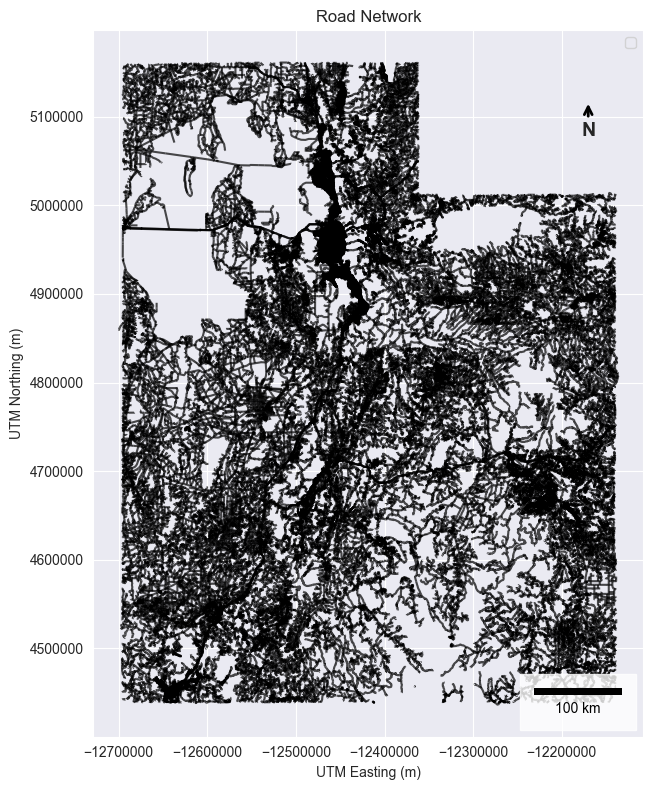

In [70]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
path = r"C:\Users\colto\Downloads\UtahRoads_-3674006339973818616\Roads.shp"
path2 = r"C:\Users\colto\Downloads\GSLFlooding_-4319570120752989084\GSLFlooding.shp"

def add_north_arrow(ax, x=0.9, y=0.9, size=0.05):
    """Add north arrow to plot"""
    ax.annotate('N', xy=(x, y), xytext=(x, y-size),
                arrowprops=dict(arrowstyle='->', lw=2, color='black'),
                fontsize=14, fontweight='bold', ha='center',
                xycoords='axes fraction')


gdf = gpd.read_file(path)

# See all data columns in geodataframe
# gdf.dtypes

#See all values in a geodataframe column
print(gdf['CARTOCODE'].unique())

# # #Assign colors to the dataframe values
road_styles = {
    'highway': {'color': 'red', 'linewidth': 3, 'label': 'Highway'},
    'primary': {'color': 'orange', 'linewidth': 2, 'label': 'Primary'},
    'secondary': {'color': 'yellow', 'linewidth': 1.5, 'label': 'Secondary'},
    'local': {'color': 'gray', 'linewidth': 1, 'label': 'Local'}
}
# #
fig, ax = plt.subplots(1, 1, figsize=(12, 8))


# fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='CARTOCODE', cmap='viridis', alpha=0.7, edgecolor='black')
add_north_arrow(ax)
# #
# # # Plot each road type separately for legend control
# for road_type, style in road_styles.items():
#     subset = gdf[gdf['road_class'] == road_type]
#     if not subset.empty:
#         subset.plot(ax=ax, **style)
# #
# # #Generate scalebar
scalebar = ScaleBar(1, "m", location="lower right",
       color="black", box_color="white", box_alpha=0.8,
       pad=1.0, border_pad=0.5, sep=5,
       length_fraction=0.2, font_properties={'size': 10})
ax.add_artist(scalebar)
# #
ax.set_title('Road Network')
ax.set_xlabel('UTM Easting (m)')
ax.set_ylabel('UTM Northing (m)')
ax.legend()

ax.ticklabel_format(style='plain')
plt.tight_layout()
plt.show()
#
#
# # Define custom colors

